In [1]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 977.1/977.1 kB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [2]:
!pip install loguru


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 5.1 MB/s eta 0:00:00


In [3]:
import argparse
from collections import defaultdict
import cv2
import numpy as np
from tqdm import tqdm
from ultralytics import YOLO
from loguru import logger


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
def load_config():
    """ Load and return configuration settings """
    return {
        "model_path": "yolo11x.pt",
        "track_history_length": 120,
        "batch_size": 64,
        "line_thickness": 4,
        "track_color": (230, 230, 230),
    }

def initialize_video(video_path):
    """ Initialize video capture and writer objects """
    cap = cv2.VideoCapture(video_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    video_name = video_path.split("/")[-1]
    output_path = f"run/{video_name.split('.')[0]}_tracked.mp4"
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    return cap, out, output_path


In [5]:
def update_track_history(
    track_history,
    last_seen,
    track_ids,
    frame_count,
    batch_size,
    frame_idx,
    history_length,
):
    """ Update tracking history and remove old tracks """
    current_tracks = set(track_ids)
    for track_id in list(track_history.keys()):
        if track_id in current_tracks:
            last_seen[track_id] = frame_count - (batch_size - frame_idx - 1)
        elif frame_count - last_seen[track_id] > history_length:
            del track_history[track_id]
            del last_seen[track_id]


In [6]:
def draw_tracks(frame, boxes, track_ids, track_history, config):
    """ Draw tracking lines on frame """
    if not track_ids:
        return frame

    for box, track_id in zip(boxes, track_ids):
        x, y, w, h = box
        track = track_history[track_id]
        track.append((float(x), float(y)))
        if len(track) > config["track_history_length"]:
            track.pop(0)

        points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
        cv2.polylines(
            frame,
            [points],
            isClosed=False,
            color=config["track_color"],
            thickness=config["line_thickness"],
        )
    return frame


In [7]:
def process_batch(model, batch_frames, track_history, last_seen, frame_count, config):
    """ Process a batch of frames through YOLO model """
    results = model.track(
        batch_frames,
        persist=True,
        tracker="botsort.yaml",
        show=False,
        verbose=False,
        iou=0.5,
    )

    processed_frames = []
    for frame_idx, result in enumerate(results):
        boxes = result.boxes.xywh.cpu()
        track_ids = (
            result.boxes.id.int().cpu().tolist() if result.boxes.id is not None
            else []
        )

        update_track_history(
            track_history,
            last_seen,
            track_ids,
            frame_count,
            len(batch_frames),
            frame_idx,
            config["track_history_length"],
        )

        annotated_frame = result.plot(font_size=4, line_width=2)
        annotated_frame = draw_tracks(
            annotated_frame, boxes, track_ids, track_history, config
        )
        processed_frames.append(annotated_frame)

    return processed_frames


In [10]:
def main(video_path):
    """ Main function to process video """
    CONFIG = load_config()
    model = YOLO(CONFIG.get("model_path", "yolo11x.pt"))

    cap, out, output_path = initialize_video(video_path)
    track_history = defaultdict(lambda: [])
    last_seen = defaultdict(int)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    with tqdm(
        total=total_frames,
        desc="Processing frames",
        colour="green",
    ) as pbar:
        frame_count = 0
        batch_frames = []

        while cap.isOpened():
            success, frame = cap.read()
            if not success:
                break

            frame_count += 1
            batch_frames.append(frame)

            if len(batch_frames) == CONFIG["batch_size"] or frame_count == total_frames:
                try:
                    processed_frames = process_batch(
                        model,
                        batch_frames,
                        track_history,
                        last_seen,
                        frame_count,
                        CONFIG,
                    )
                    for frame in processed_frames:
                        out.write(frame)
                        pbar.update(1)
                    batch_frames = []

                except Exception as e:
                    logger.error(
                        f"Error when handling frames {frame_count - len(batch_frames) + 1} to {frame_count}: {str(e)}"
                    )
                    batch_frames = []
                    continue

    try:
        cap.release()
        out.release()
        cv2.destroyAllWindows()
        logger.info(f"\nVideo has been saved to {output_path}")
    except Exception as e:
        logger.error(f"Error during cleanup: {str(e)}")


# Gọi trực tiếp hàm main với video path
video_path = "/content/vietnam-2.mp4"  # Thay đổi đường dẫn video tại đây
main(video_path)


Processing frames:   0%|          | 0/780 [00:00<?, ?it/s]

requirements: Ultralytics requirement ['lap>=0.5.12'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 167.0 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 2.3s, installed 1 package: ['lap>=0.5.12']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



Processing frames: 100%|██████████| 780/780 [00:57<00:00, 13.64it/s]
2025-04-03 10:08:07.144 | INFO     | __main__:main:53 - 
Video has been saved to run/vietnam-2_tracked.mp4


In [11]:
import os

# Đảm bảo thư mục 'run' đã tồn tại
output_dir = "/content/run/"
os.makedirs(output_dir, exist_ok=True)

# Đường dẫn tệp video đầu ra
output_path = os.path.join(output_dir, "vietnam-2_tracked.mp4")
print(f"Video will be saved to: {output_path}")


Video will be saved to: /content/run/vietnam-2_tracked.mp4


In [12]:
!ls /content/run/


In [13]:
from ultralytics import YOLO
import cv2
from tqdm import tqdm
import os

# Tải mô hình YOLO
model = YOLO('yolo11x.pt')

# Đọc video
video_path = '/content/vietnam-2.mp4'
cap = cv2.VideoCapture(video_path)

# Đọc và xử lý video
output_dir = '/content/run/'
os.makedirs(output_dir, exist_ok=True)

output_path = f"{output_dir}/vietnam-2_tracked.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

# Tiến hành xử lý video
with tqdm(total=int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), desc="Processing frames", colour="green") as pbar:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Xử lý frame bằng YOLO
        results = model.track(frame, persist=True, show=False)

        # Ghi video đã xử lý
        out.write(results[0].plot())
        pbar.update(1)

cap.release()
out.release()

print(f"Video has been saved to {output_path}")


Processing frames:   0%|          | 0/780 [00:00<?, ?it/s]


0: 384x640 19 persons, 4 cars, 26 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 backpack, 72.6ms
Speed: 2.5ms preprocess, 72.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   0%|          | 1/780 [00:00<12:09,  1.07it/s]


0: 384x640 19 persons, 4 cars, 26 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 backpack, 21.6ms
Speed: 2.6ms preprocess, 21.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   0%|          | 2/780 [00:01<05:59,  2.17it/s]


0: 384x640 18 persons, 4 cars, 26 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 backpack, 21.2ms
Speed: 2.5ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   0%|          | 3/780 [00:01<03:57,  3.27it/s]


0: 384x640 18 persons, 4 cars, 25 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 backpack, 21.0ms
Speed: 2.5ms preprocess, 21.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   1%|          | 4/780 [00:01<02:59,  4.31it/s]


0: 384x640 18 persons, 4 cars, 25 motorcycles, 2 buss, 2 trucks, 1 stop sign, 1 backpack, 21.0ms
Speed: 2.5ms preprocess, 21.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   1%|          | 5/780 [00:01<02:27,  5.25it/s]


0: 384x640 20 persons, 4 cars, 25 motorcycles, 2 buss, 2 trucks, 1 stop sign, 1 backpack, 20.9ms
Speed: 2.5ms preprocess, 20.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   1%|          | 6/780 [00:01<02:08,  6.01it/s]


0: 384x640 19 persons, 4 cars, 28 motorcycles, 2 buss, 2 trucks, 1 stop sign, 1 backpack, 22.9ms
Speed: 3.7ms preprocess, 22.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   1%|          | 7/780 [00:01<01:58,  6.54it/s]


0: 384x640 19 persons, 4 cars, 28 motorcycles, 2 buss, 2 trucks, 1 stop sign, 1 backpack, 20.8ms
Speed: 2.5ms preprocess, 20.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   1%|          | 8/780 [00:01<01:50,  7.01it/s]


0: 384x640 19 persons, 3 cars, 28 motorcycles, 1 bus, 1 truck, 1 stop sign, 1 backpack, 21.1ms
Speed: 2.4ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   1%|          | 9/780 [00:01<01:44,  7.38it/s]


0: 384x640 19 persons, 3 cars, 29 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 backpack, 22.2ms
Speed: 2.5ms preprocess, 22.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   1%|▏         | 10/780 [00:02<01:41,  7.59it/s]


0: 384x640 19 persons, 3 cars, 30 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 backpack, 20.9ms
Speed: 2.5ms preprocess, 20.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   1%|▏         | 11/780 [00:02<01:38,  7.78it/s]


0: 384x640 20 persons, 3 cars, 29 motorcycles, 2 buss, 1 truck, 1 stop sign, 1 backpack, 20.9ms
Speed: 2.5ms preprocess, 20.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   2%|▏         | 12/780 [00:02<01:37,  7.88it/s]


0: 384x640 20 persons, 3 cars, 28 motorcycles, 2 buss, 1 truck, 1 stop sign, 1 backpack, 21.9ms
Speed: 2.5ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   2%|▏         | 13/780 [00:02<01:36,  7.91it/s]


0: 384x640 20 persons, 3 cars, 28 motorcycles, 2 buss, 1 truck, 1 stop sign, 1 backpack, 20.7ms
Speed: 2.4ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   2%|▏         | 14/780 [00:02<01:35,  8.04it/s]


0: 384x640 19 persons, 3 cars, 27 motorcycles, 2 buss, 1 truck, 1 stop sign, 1 backpack, 21.7ms
Speed: 2.5ms preprocess, 21.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   2%|▏         | 15/780 [00:02<01:34,  8.11it/s]


0: 384x640 19 persons, 3 cars, 27 motorcycles, 2 buss, 1 truck, 1 stop sign, 1 backpack, 20.5ms
Speed: 2.4ms preprocess, 20.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   2%|▏         | 16/780 [00:02<01:33,  8.19it/s]


0: 384x640 19 persons, 3 cars, 27 motorcycles, 2 buss, 1 truck, 1 stop sign, 1 backpack, 20.7ms
Speed: 2.7ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   2%|▏         | 17/780 [00:02<01:32,  8.24it/s]


0: 384x640 19 persons, 3 cars, 27 motorcycles, 2 buss, 1 truck, 1 stop sign, 1 backpack, 20.6ms
Speed: 2.6ms preprocess, 20.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   2%|▏         | 18/780 [00:02<01:31,  8.28it/s]


0: 384x640 19 persons, 3 cars, 25 motorcycles, 2 buss, 1 truck, 1 stop sign, 1 backpack, 22.5ms
Speed: 3.7ms preprocess, 22.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   2%|▏         | 19/780 [00:03<01:32,  8.26it/s]


0: 384x640 19 persons, 4 cars, 25 motorcycles, 2 buss, 1 truck, 1 stop sign, 1 backpack, 20.6ms
Speed: 2.5ms preprocess, 20.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   3%|▎         | 20/780 [00:03<01:31,  8.30it/s]


0: 384x640 19 persons, 4 cars, 26 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 backpack, 20.5ms
Speed: 2.5ms preprocess, 20.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   3%|▎         | 21/780 [00:03<01:31,  8.29it/s]


0: 384x640 19 persons, 4 cars, 26 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 backpack, 20.4ms
Speed: 2.5ms preprocess, 20.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   3%|▎         | 22/780 [00:03<01:30,  8.35it/s]


0: 384x640 19 persons, 4 cars, 28 motorcycles, 2 buss, 2 trucks, 1 stop sign, 1 backpack, 20.5ms
Speed: 2.4ms preprocess, 20.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   3%|▎         | 23/780 [00:03<01:30,  8.33it/s]


0: 384x640 18 persons, 4 cars, 28 motorcycles, 2 buss, 2 trucks, 1 stop sign, 1 backpack, 20.6ms
Speed: 2.4ms preprocess, 20.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   3%|▎         | 24/780 [00:03<01:30,  8.32it/s]


0: 384x640 18 persons, 4 cars, 28 motorcycles, 3 buss, 2 trucks, 1 stop sign, 1 backpack, 20.6ms
Speed: 2.4ms preprocess, 20.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   3%|▎         | 25/780 [00:03<01:31,  8.26it/s]


0: 384x640 18 persons, 4 cars, 28 motorcycles, 2 buss, 3 trucks, 1 stop sign, 1 backpack, 20.6ms
Speed: 2.4ms preprocess, 20.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   3%|▎         | 26/780 [00:03<01:31,  8.26it/s]


0: 384x640 18 persons, 4 cars, 28 motorcycles, 2 buss, 3 trucks, 1 stop sign, 1 backpack, 20.7ms
Speed: 2.4ms preprocess, 20.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   3%|▎         | 27/780 [00:04<01:31,  8.26it/s]


0: 384x640 19 persons, 4 cars, 28 motorcycles, 3 buss, 3 trucks, 1 stop sign, 1 backpack, 21.0ms
Speed: 2.5ms preprocess, 21.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   4%|▎         | 28/780 [00:04<01:31,  8.21it/s]


0: 384x640 19 persons, 4 cars, 28 motorcycles, 3 buss, 3 trucks, 1 stop sign, 1 backpack, 21.7ms
Speed: 2.6ms preprocess, 21.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   4%|▎         | 29/780 [00:04<01:32,  8.10it/s]


0: 384x640 19 persons, 4 cars, 26 motorcycles, 3 buss, 3 trucks, 1 stop sign, 1 backpack, 21.1ms
Speed: 2.6ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   4%|▍         | 30/780 [00:04<01:32,  8.14it/s]


0: 384x640 19 persons, 4 cars, 27 motorcycles, 3 buss, 2 trucks, 1 stop sign, 1 backpack, 23.1ms
Speed: 3.7ms preprocess, 23.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   4%|▍         | 31/780 [00:04<01:32,  8.10it/s]


0: 384x640 19 persons, 4 cars, 28 motorcycles, 2 buss, 3 trucks, 1 stop sign, 1 backpack, 21.7ms
Speed: 2.4ms preprocess, 21.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   4%|▍         | 32/780 [00:04<01:32,  8.07it/s]


0: 384x640 18 persons, 4 cars, 28 motorcycles, 2 buss, 3 trucks, 1 stop sign, 1 backpack, 21.1ms
Speed: 2.5ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   4%|▍         | 33/780 [00:04<01:33,  8.03it/s]


0: 384x640 18 persons, 4 cars, 28 motorcycles, 2 buss, 3 trucks, 1 stop sign, 1 backpack, 22.5ms
Speed: 2.5ms preprocess, 22.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   4%|▍         | 34/780 [00:04<01:32,  8.04it/s]


0: 384x640 18 persons, 4 cars, 28 motorcycles, 2 buss, 3 trucks, 1 stop sign, 1 backpack, 21.3ms
Speed: 2.5ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   4%|▍         | 35/780 [00:05<01:32,  8.07it/s]


0: 384x640 18 persons, 4 cars, 28 motorcycles, 2 buss, 3 trucks, 1 stop sign, 1 backpack, 21.1ms
Speed: 2.8ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   5%|▍         | 36/780 [00:05<01:31,  8.10it/s]


0: 384x640 18 persons, 4 cars, 26 motorcycles, 2 buss, 3 trucks, 1 stop sign, 1 backpack, 21.6ms
Speed: 2.7ms preprocess, 21.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   5%|▍         | 37/780 [00:05<01:32,  8.04it/s]


0: 384x640 18 persons, 4 cars, 26 motorcycles, 2 buss, 3 trucks, 1 stop sign, 1 backpack, 21.8ms
Speed: 3.7ms preprocess, 21.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   5%|▍         | 38/780 [00:05<01:32,  8.05it/s]


0: 384x640 18 persons, 4 cars, 26 motorcycles, 2 buss, 3 trucks, 1 stop sign, 1 backpack, 21.5ms
Speed: 2.5ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   5%|▌         | 39/780 [00:05<01:32,  8.04it/s]


0: 384x640 18 persons, 4 cars, 25 motorcycles, 2 buss, 3 trucks, 1 stop sign, 1 backpack, 23.9ms
Speed: 2.5ms preprocess, 23.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   5%|▌         | 40/780 [00:05<01:32,  7.98it/s]


0: 384x640 18 persons, 4 cars, 25 motorcycles, 2 buss, 3 trucks, 1 stop sign, 1 backpack, 23.7ms
Speed: 2.7ms preprocess, 23.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   5%|▌         | 41/780 [00:05<01:33,  7.90it/s]


0: 384x640 18 persons, 4 cars, 26 motorcycles, 2 buss, 3 trucks, 1 stop sign, 1 backpack, 21.1ms
Speed: 2.8ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   5%|▌         | 42/780 [00:05<01:32,  7.97it/s]


0: 384x640 18 persons, 4 cars, 26 motorcycles, 2 buss, 3 trucks, 1 stop sign, 1 backpack, 23.2ms
Speed: 2.6ms preprocess, 23.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   6%|▌         | 43/780 [00:06<01:32,  7.96it/s]


0: 384x640 18 persons, 4 cars, 26 motorcycles, 2 buss, 3 trucks, 1 stop sign, 1 backpack, 22.7ms
Speed: 3.7ms preprocess, 22.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   6%|▌         | 44/780 [00:06<01:32,  7.96it/s]


0: 384x640 18 persons, 4 cars, 27 motorcycles, 2 buss, 3 trucks, 1 stop sign, 1 backpack, 21.7ms
Speed: 2.6ms preprocess, 21.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   6%|▌         | 45/780 [00:06<01:31,  7.99it/s]


0: 384x640 18 persons, 4 cars, 27 motorcycles, 2 buss, 3 trucks, 1 stop sign, 1 backpack, 22.1ms
Speed: 2.9ms preprocess, 22.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   6%|▌         | 46/780 [00:06<01:31,  8.00it/s]


0: 384x640 18 persons, 4 cars, 27 motorcycles, 2 buss, 3 trucks, 1 stop sign, 1 backpack, 21.3ms
Speed: 2.5ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   6%|▌         | 47/780 [00:06<01:31,  8.03it/s]


0: 384x640 18 persons, 4 cars, 27 motorcycles, 2 buss, 3 trucks, 1 stop sign, 1 backpack, 22.2ms
Speed: 2.6ms preprocess, 22.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   6%|▌         | 48/780 [00:06<01:31,  8.01it/s]


0: 384x640 18 persons, 4 cars, 28 motorcycles, 2 buss, 3 trucks, 1 stop sign, 1 backpack, 21.6ms
Speed: 2.9ms preprocess, 21.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   6%|▋         | 49/780 [00:06<01:31,  7.97it/s]


0: 384x640 18 persons, 3 cars, 27 motorcycles, 2 buss, 2 trucks, 1 stop sign, 1 backpack, 21.9ms
Speed: 3.7ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   6%|▋         | 50/780 [00:06<01:31,  7.98it/s]


0: 384x640 18 persons, 5 cars, 27 motorcycles, 2 buss, 1 truck, 1 stop sign, 1 backpack, 21.5ms
Speed: 2.4ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   7%|▋         | 51/780 [00:07<01:31,  8.01it/s]


0: 384x640 19 persons, 1 bicycle, 5 cars, 27 motorcycles, 2 buss, 1 truck, 1 stop sign, 1 backpack, 21.4ms
Speed: 2.9ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   7%|▋         | 52/780 [00:07<01:31,  7.98it/s]


0: 384x640 19 persons, 1 bicycle, 5 cars, 26 motorcycles, 3 buss, 1 truck, 1 stop sign, 1 backpack, 21.9ms
Speed: 2.5ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   7%|▋         | 53/780 [00:07<01:31,  7.95it/s]


0: 384x640 19 persons, 1 bicycle, 5 cars, 28 motorcycles, 3 buss, 1 truck, 1 stop sign, 1 backpack, 22.3ms
Speed: 2.5ms preprocess, 22.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   7%|▋         | 54/780 [00:07<01:32,  7.89it/s]


0: 384x640 19 persons, 1 bicycle, 5 cars, 26 motorcycles, 3 buss, 1 truck, 1 stop sign, 1 backpack, 22.3ms
Speed: 2.6ms preprocess, 22.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   7%|▋         | 55/780 [00:07<01:31,  7.89it/s]


0: 384x640 20 persons, 1 bicycle, 5 cars, 25 motorcycles, 3 buss, 1 stop sign, 1 backpack, 21.5ms
Speed: 2.7ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   7%|▋         | 56/780 [00:07<01:31,  7.90it/s]


0: 384x640 20 persons, 1 bicycle, 5 cars, 25 motorcycles, 3 buss, 1 stop sign, 1 backpack, 22.7ms
Speed: 2.5ms preprocess, 22.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   7%|▋         | 57/780 [00:07<01:31,  7.88it/s]


0: 384x640 20 persons, 1 bicycle, 5 cars, 27 motorcycles, 3 buss, 1 stop sign, 1 backpack, 22.5ms
Speed: 2.6ms preprocess, 22.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   7%|▋         | 58/780 [00:07<01:32,  7.84it/s]


0: 384x640 20 persons, 1 bicycle, 5 cars, 26 motorcycles, 3 buss, 1 truck, 1 stop sign, 1 backpack, 22.2ms
Speed: 2.5ms preprocess, 22.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   8%|▊         | 59/780 [00:08<01:32,  7.84it/s]


0: 384x640 20 persons, 1 bicycle, 5 cars, 25 motorcycles, 2 buss, 1 truck, 1 stop sign, 1 backpack, 22.1ms
Speed: 2.5ms preprocess, 22.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   8%|▊         | 60/780 [00:08<01:31,  7.86it/s]


0: 384x640 21 persons, 1 bicycle, 5 cars, 25 motorcycles, 2 buss, 1 truck, 1 stop sign, 1 backpack, 22.2ms
Speed: 2.6ms preprocess, 22.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   8%|▊         | 61/780 [00:08<01:31,  7.84it/s]


0: 384x640 20 persons, 1 bicycle, 5 cars, 24 motorcycles, 2 buss, 1 truck, 1 stop sign, 1 backpack, 22.1ms
Speed: 2.6ms preprocess, 22.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   8%|▊         | 62/780 [00:08<01:30,  7.89it/s]


0: 384x640 20 persons, 1 bicycle, 5 cars, 24 motorcycles, 2 buss, 1 truck, 1 stop sign, 1 backpack, 21.9ms
Speed: 2.6ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   8%|▊         | 63/780 [00:08<01:30,  7.89it/s]


0: 384x640 20 persons, 1 bicycle, 5 cars, 24 motorcycles, 2 buss, 1 truck, 1 stop sign, 1 backpack, 22.7ms
Speed: 2.7ms preprocess, 22.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   8%|▊         | 64/780 [00:08<01:31,  7.86it/s]


0: 384x640 20 persons, 1 bicycle, 5 cars, 23 motorcycles, 2 buss, 1 truck, 1 stop sign, 1 backpack, 22.0ms
Speed: 2.5ms preprocess, 22.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   8%|▊         | 65/780 [00:08<01:30,  7.90it/s]


0: 384x640 20 persons, 1 bicycle, 6 cars, 23 motorcycles, 2 buss, 1 stop sign, 1 backpack, 22.7ms
Speed: 2.6ms preprocess, 22.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   8%|▊         | 66/780 [00:08<01:29,  7.96it/s]


0: 384x640 20 persons, 1 bicycle, 6 cars, 24 motorcycles, 2 buss, 1 stop sign, 1 backpack, 21.4ms
Speed: 2.5ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   9%|▊         | 67/780 [00:09<01:28,  8.01it/s]


0: 384x640 20 persons, 1 bicycle, 6 cars, 23 motorcycles, 2 buss, 1 stop sign, 1 backpack, 21.4ms
Speed: 2.5ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   9%|▊         | 68/780 [00:09<01:28,  8.06it/s]


0: 384x640 20 persons, 1 bicycle, 6 cars, 23 motorcycles, 2 buss, 1 stop sign, 1 backpack, 21.9ms
Speed: 2.6ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   9%|▉         | 69/780 [00:09<01:27,  8.09it/s]


0: 384x640 20 persons, 6 cars, 24 motorcycles, 2 buss, 1 stop sign, 1 backpack, 21.1ms
Speed: 2.5ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   9%|▉         | 70/780 [00:09<01:27,  8.12it/s]


0: 384x640 20 persons, 6 cars, 25 motorcycles, 2 buss, 1 stop sign, 1 backpack, 21.1ms
Speed: 2.5ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   9%|▉         | 71/780 [00:09<01:27,  8.14it/s]


0: 384x640 20 persons, 6 cars, 24 motorcycles, 2 buss, 1 stop sign, 1 backpack, 21.8ms
Speed: 2.4ms preprocess, 21.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   9%|▉         | 72/780 [00:09<01:26,  8.19it/s]


0: 384x640 20 persons, 6 cars, 23 motorcycles, 2 buss, 1 truck, 1 stop sign, 1 backpack, 21.0ms
Speed: 2.5ms preprocess, 21.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   9%|▉         | 73/780 [00:09<01:26,  8.19it/s]


0: 384x640 20 persons, 6 cars, 23 motorcycles, 2 buss, 1 truck, 1 stop sign, 1 backpack, 21.0ms
Speed: 2.6ms preprocess, 21.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:   9%|▉         | 74/780 [00:09<01:25,  8.25it/s]


0: 384x640 20 persons, 6 cars, 23 motorcycles, 2 buss, 1 truck, 1 stop sign, 1 backpack, 21.8ms
Speed: 2.5ms preprocess, 21.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  10%|▉         | 75/780 [00:10<01:25,  8.24it/s]


0: 384x640 20 persons, 6 cars, 23 motorcycles, 2 buss, 1 truck, 1 stop sign, 1 backpack, 21.2ms
Speed: 2.5ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  10%|▉         | 76/780 [00:10<01:25,  8.24it/s]


0: 384x640 20 persons, 6 cars, 23 motorcycles, 2 buss, 1 stop sign, 1 backpack, 21.0ms
Speed: 2.5ms preprocess, 21.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  10%|▉         | 77/780 [00:10<01:25,  8.25it/s]


0: 384x640 20 persons, 6 cars, 23 motorcycles, 2 buss, 1 stop sign, 1 backpack, 20.5ms
Speed: 2.5ms preprocess, 20.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  10%|█         | 78/780 [00:10<01:24,  8.27it/s]


0: 384x640 20 persons, 6 cars, 24 motorcycles, 2 buss, 1 stop sign, 1 backpack, 20.9ms
Speed: 2.5ms preprocess, 20.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  10%|█         | 79/780 [00:10<01:24,  8.29it/s]


0: 384x640 19 persons, 5 cars, 25 motorcycles, 2 buss, 1 truck, 1 stop sign, 1 backpack, 20.8ms
Speed: 2.5ms preprocess, 20.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  10%|█         | 80/780 [00:10<01:24,  8.29it/s]


0: 384x640 19 persons, 6 cars, 24 motorcycles, 2 buss, 1 stop sign, 1 backpack, 21.2ms
Speed: 2.5ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  10%|█         | 81/780 [00:10<01:24,  8.30it/s]


0: 384x640 19 persons, 6 cars, 24 motorcycles, 2 buss, 1 stop sign, 1 backpack, 20.9ms
Speed: 2.8ms preprocess, 20.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  11%|█         | 82/780 [00:10<01:23,  8.32it/s]


0: 384x640 19 persons, 6 cars, 24 motorcycles, 2 buss, 1 stop sign, 1 backpack, 21.1ms
Speed: 2.5ms preprocess, 21.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  11%|█         | 83/780 [00:11<01:23,  8.32it/s]


0: 384x640 19 persons, 6 cars, 25 motorcycles, 2 buss, 1 stop sign, 1 backpack, 20.9ms
Speed: 2.5ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  11%|█         | 84/780 [00:11<01:23,  8.35it/s]


0: 384x640 19 persons, 6 cars, 24 motorcycles, 2 buss, 1 stop sign, 1 backpack, 21.5ms
Speed: 2.5ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  11%|█         | 85/780 [00:11<01:23,  8.29it/s]


0: 384x640 19 persons, 6 cars, 25 motorcycles, 2 buss, 1 stop sign, 1 backpack, 20.8ms
Speed: 2.5ms preprocess, 20.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  11%|█         | 86/780 [00:11<01:23,  8.31it/s]


0: 384x640 19 persons, 6 cars, 25 motorcycles, 2 buss, 1 stop sign, 1 backpack, 20.6ms
Speed: 2.5ms preprocess, 20.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  11%|█         | 87/780 [00:11<01:23,  8.31it/s]


0: 384x640 19 persons, 6 cars, 25 motorcycles, 2 buss, 1 stop sign, 1 backpack, 20.6ms
Speed: 2.4ms preprocess, 20.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  11%|█▏        | 88/780 [00:11<01:23,  8.33it/s]


0: 384x640 19 persons, 6 cars, 25 motorcycles, 2 buss, 1 stop sign, 1 backpack, 20.7ms
Speed: 2.5ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  11%|█▏        | 89/780 [00:11<01:22,  8.36it/s]


0: 384x640 20 persons, 6 cars, 25 motorcycles, 2 buss, 1 stop sign, 1 backpack, 20.6ms
Speed: 2.4ms preprocess, 20.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  12%|█▏        | 90/780 [00:11<01:22,  8.36it/s]


0: 384x640 19 persons, 6 cars, 25 motorcycles, 2 buss, 1 stop sign, 1 backpack, 21.3ms
Speed: 2.4ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  12%|█▏        | 91/780 [00:12<01:22,  8.33it/s]


0: 384x640 20 persons, 6 cars, 24 motorcycles, 2 buss, 1 stop sign, 1 backpack, 20.6ms
Speed: 2.4ms preprocess, 20.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  12%|█▏        | 92/780 [00:12<01:22,  8.36it/s]


0: 384x640 21 persons, 6 cars, 24 motorcycles, 2 buss, 1 truck, 1 stop sign, 1 backpack, 21.7ms
Speed: 2.6ms preprocess, 21.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  12%|█▏        | 93/780 [00:12<01:23,  8.26it/s]


0: 384x640 21 persons, 6 cars, 24 motorcycles, 2 buss, 2 trucks, 1 stop sign, 1 backpack, 22.0ms
Speed: 2.9ms preprocess, 22.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  12%|█▏        | 94/780 [00:12<01:23,  8.19it/s]


0: 384x640 21 persons, 6 cars, 25 motorcycles, 2 buss, 2 trucks, 1 stop sign, 1 backpack, 21.3ms
Speed: 2.8ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  12%|█▏        | 95/780 [00:12<01:24,  8.14it/s]


0: 384x640 21 persons, 6 cars, 25 motorcycles, 2 buss, 2 trucks, 1 stop sign, 1 backpack, 21.9ms
Speed: 2.5ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  12%|█▏        | 96/780 [00:12<01:24,  8.09it/s]


0: 384x640 21 persons, 6 cars, 24 motorcycles, 2 buss, 2 trucks, 1 stop sign, 1 backpack, 22.4ms
Speed: 2.6ms preprocess, 22.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  12%|█▏        | 97/780 [00:12<01:25,  8.02it/s]


0: 384x640 21 persons, 5 cars, 24 motorcycles, 2 buss, 1 truck, 1 stop sign, 1 backpack, 21.9ms
Speed: 2.6ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  13%|█▎        | 98/780 [00:12<01:24,  8.07it/s]


0: 384x640 21 persons, 6 cars, 24 motorcycles, 2 buss, 1 truck, 1 stop sign, 1 backpack, 21.7ms
Speed: 2.5ms preprocess, 21.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  13%|█▎        | 99/780 [00:12<01:24,  8.08it/s]


0: 384x640 21 persons, 6 cars, 23 motorcycles, 2 buss, 1 stop sign, 1 backpack, 21.9ms
Speed: 2.5ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  13%|█▎        | 100/780 [00:13<01:23,  8.13it/s]


0: 384x640 21 persons, 6 cars, 24 motorcycles, 2 buss, 1 stop sign, 1 backpack, 21.3ms
Speed: 2.6ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  13%|█▎        | 101/780 [00:13<01:23,  8.17it/s]


0: 384x640 21 persons, 6 cars, 24 motorcycles, 2 buss, 1 truck, 1 stop sign, 1 backpack, 22.3ms
Speed: 2.6ms preprocess, 22.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  13%|█▎        | 102/780 [00:13<01:23,  8.15it/s]


0: 384x640 21 persons, 4 cars, 24 motorcycles, 2 buss, 3 trucks, 1 stop sign, 1 backpack, 21.6ms
Speed: 2.6ms preprocess, 21.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  13%|█▎        | 103/780 [00:13<01:23,  8.12it/s]


0: 384x640 21 persons, 5 cars, 24 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 backpack, 21.5ms
Speed: 3.1ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  13%|█▎        | 104/780 [00:13<01:23,  8.12it/s]


0: 384x640 21 persons, 5 cars, 24 motorcycles, 2 buss, 2 trucks, 1 stop sign, 1 backpack, 21.4ms
Speed: 2.9ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  13%|█▎        | 105/780 [00:13<01:22,  8.17it/s]


0: 384x640 20 persons, 5 cars, 25 motorcycles, 2 buss, 3 trucks, 1 stop sign, 1 backpack, 21.9ms
Speed: 3.3ms preprocess, 21.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  14%|█▎        | 106/780 [00:13<01:22,  8.16it/s]


0: 384x640 20 persons, 6 cars, 25 motorcycles, 2 buss, 2 trucks, 1 stop sign, 1 backpack, 21.4ms
Speed: 2.4ms preprocess, 21.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  14%|█▎        | 107/780 [00:13<01:22,  8.17it/s]


0: 384x640 20 persons, 6 cars, 24 motorcycles, 2 buss, 2 trucks, 1 stop sign, 1 backpack, 21.6ms
Speed: 2.5ms preprocess, 21.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  14%|█▍        | 108/780 [00:14<01:22,  8.18it/s]


0: 384x640 20 persons, 6 cars, 24 motorcycles, 2 buss, 2 trucks, 1 stop sign, 1 backpack, 20.8ms
Speed: 2.5ms preprocess, 20.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  14%|█▍        | 109/780 [00:14<01:22,  8.16it/s]


0: 384x640 20 persons, 6 cars, 22 motorcycles, 2 buss, 2 trucks, 1 stop sign, 1 backpack, 21.6ms
Speed: 3.0ms preprocess, 21.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  14%|█▍        | 110/780 [00:14<01:22,  8.16it/s]


0: 384x640 20 persons, 6 cars, 22 motorcycles, 2 buss, 2 trucks, 1 stop sign, 1 backpack, 21.3ms
Speed: 2.5ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  14%|█▍        | 111/780 [00:14<01:21,  8.23it/s]


0: 384x640 19 persons, 6 cars, 22 motorcycles, 2 buss, 2 trucks, 1 stop sign, 1 backpack, 20.8ms
Speed: 2.5ms preprocess, 20.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  14%|█▍        | 112/780 [00:14<01:20,  8.29it/s]


0: 384x640 19 persons, 6 cars, 24 motorcycles, 2 buss, 2 trucks, 1 stop sign, 1 backpack, 21.3ms
Speed: 2.5ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  14%|█▍        | 113/780 [00:14<01:20,  8.29it/s]


0: 384x640 19 persons, 5 cars, 24 motorcycles, 2 buss, 1 truck, 1 stop sign, 1 backpack, 20.6ms
Speed: 2.5ms preprocess, 20.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  15%|█▍        | 114/780 [00:14<01:20,  8.32it/s]


0: 384x640 19 persons, 6 cars, 24 motorcycles, 2 buss, 1 truck, 1 stop sign, 1 backpack, 20.8ms
Speed: 3.2ms preprocess, 20.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  15%|█▍        | 115/780 [00:14<01:19,  8.33it/s]


0: 384x640 19 persons, 6 cars, 21 motorcycles, 2 buss, 1 truck, 1 stop sign, 1 backpack, 21.0ms
Speed: 2.5ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  15%|█▍        | 116/780 [00:15<01:19,  8.33it/s]


0: 384x640 19 persons, 6 cars, 20 motorcycles, 2 buss, 2 trucks, 1 stop sign, 1 backpack, 22.0ms
Speed: 2.8ms preprocess, 22.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  15%|█▌        | 117/780 [00:15<01:19,  8.37it/s]


0: 384x640 20 persons, 6 cars, 20 motorcycles, 2 buss, 3 trucks, 1 stop sign, 1 backpack, 24.1ms
Speed: 2.4ms preprocess, 24.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  15%|█▌        | 118/780 [00:15<01:19,  8.28it/s]


0: 384x640 19 persons, 6 cars, 21 motorcycles, 1 bus, 3 trucks, 1 stop sign, 1 backpack, 20.8ms
Speed: 2.5ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  15%|█▌        | 119/780 [00:15<01:19,  8.34it/s]


0: 384x640 18 persons, 6 cars, 19 motorcycles, 1 bus, 3 trucks, 1 stop sign, 1 backpack, 21.1ms
Speed: 2.5ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  15%|█▌        | 120/780 [00:15<01:18,  8.41it/s]


0: 384x640 18 persons, 6 cars, 22 motorcycles, 1 bus, 3 trucks, 1 stop sign, 1 backpack, 21.4ms
Speed: 2.7ms preprocess, 21.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  16%|█▌        | 121/780 [00:15<01:18,  8.37it/s]


0: 384x640 18 persons, 6 cars, 21 motorcycles, 1 bus, 3 trucks, 1 stop sign, 1 backpack, 20.9ms
Speed: 3.2ms preprocess, 20.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  16%|█▌        | 122/780 [00:15<01:18,  8.43it/s]


0: 384x640 18 persons, 6 cars, 21 motorcycles, 1 bus, 3 trucks, 1 stop sign, 1 backpack, 21.6ms
Speed: 3.2ms preprocess, 21.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  16%|█▌        | 123/780 [00:15<01:18,  8.42it/s]


0: 384x640 18 persons, 6 cars, 22 motorcycles, 2 buss, 3 trucks, 1 stop sign, 1 backpack, 21.3ms
Speed: 2.5ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  16%|█▌        | 124/780 [00:16<01:18,  8.40it/s]


0: 384x640 18 persons, 6 cars, 21 motorcycles, 2 buss, 3 trucks, 1 stop sign, 1 backpack, 21.7ms
Speed: 3.5ms preprocess, 21.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  16%|█▌        | 125/780 [00:16<01:18,  8.33it/s]


0: 384x640 19 persons, 6 cars, 21 motorcycles, 2 buss, 3 trucks, 1 backpack, 22.1ms
Speed: 2.6ms preprocess, 22.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  16%|█▌        | 126/780 [00:16<01:18,  8.30it/s]


0: 384x640 19 persons, 6 cars, 20 motorcycles, 2 buss, 3 trucks, 1 backpack, 21.8ms
Speed: 2.8ms preprocess, 21.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  16%|█▋        | 127/780 [00:16<01:18,  8.31it/s]


0: 384x640 18 persons, 6 cars, 21 motorcycles, 2 buss, 3 trucks, 1 backpack, 24.2ms
Speed: 2.9ms preprocess, 24.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  16%|█▋        | 128/780 [00:16<01:18,  8.26it/s]


0: 384x640 18 persons, 6 cars, 21 motorcycles, 2 buss, 3 trucks, 1 backpack, 21.9ms
Speed: 3.2ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  17%|█▋        | 129/780 [00:16<01:18,  8.27it/s]


0: 384x640 19 persons, 6 cars, 21 motorcycles, 2 buss, 4 trucks, 1 backpack, 21.9ms
Speed: 2.5ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  17%|█▋        | 130/780 [00:16<01:19,  8.21it/s]


0: 384x640 19 persons, 6 cars, 22 motorcycles, 2 buss, 4 trucks, 1 backpack, 21.9ms
Speed: 2.6ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  17%|█▋        | 131/780 [00:16<01:19,  8.21it/s]


0: 384x640 19 persons, 6 cars, 21 motorcycles, 2 buss, 4 trucks, 1 backpack, 22.0ms
Speed: 3.3ms preprocess, 22.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  17%|█▋        | 132/780 [00:16<01:18,  8.23it/s]


0: 384x640 19 persons, 6 cars, 21 motorcycles, 2 buss, 3 trucks, 1 backpack, 21.9ms
Speed: 2.5ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  17%|█▋        | 133/780 [00:17<01:19,  8.18it/s]


0: 384x640 19 persons, 6 cars, 20 motorcycles, 2 buss, 3 trucks, 1 backpack, 21.7ms
Speed: 2.5ms preprocess, 21.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  17%|█▋        | 134/780 [00:17<01:18,  8.24it/s]


0: 384x640 19 persons, 6 cars, 22 motorcycles, 2 buss, 3 trucks, 1 backpack, 21.8ms
Speed: 2.6ms preprocess, 21.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  17%|█▋        | 135/780 [00:17<01:18,  8.19it/s]


0: 384x640 19 persons, 6 cars, 22 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.8ms
Speed: 3.2ms preprocess, 21.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  17%|█▋        | 136/780 [00:17<01:18,  8.20it/s]


0: 384x640 19 persons, 6 cars, 21 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.9ms
Speed: 2.5ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  18%|█▊        | 137/780 [00:17<01:18,  8.23it/s]


0: 384x640 19 persons, 6 cars, 21 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.4ms
Speed: 3.2ms preprocess, 22.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  18%|█▊        | 138/780 [00:17<01:17,  8.26it/s]


0: 384x640 20 persons, 6 cars, 21 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.3ms
Speed: 2.4ms preprocess, 21.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  18%|█▊        | 139/780 [00:17<01:17,  8.28it/s]


0: 384x640 20 persons, 6 cars, 22 motorcycles, 1 bus, 1 truck, 1 traffic light, 1 backpack, 21.1ms
Speed: 3.3ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  18%|█▊        | 140/780 [00:17<01:17,  8.31it/s]


0: 384x640 20 persons, 6 cars, 22 motorcycles, 1 bus, 1 truck, 1 traffic light, 1 backpack, 21.9ms
Speed: 2.8ms preprocess, 21.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  18%|█▊        | 141/780 [00:18<01:17,  8.29it/s]


0: 384x640 20 persons, 6 cars, 23 motorcycles, 1 bus, 1 truck, 1 traffic light, 1 backpack, 21.2ms
Speed: 2.5ms preprocess, 21.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  18%|█▊        | 142/780 [00:18<01:17,  8.28it/s]


0: 384x640 20 persons, 6 cars, 22 motorcycles, 1 bus, 1 truck, 1 traffic light, 1 backpack, 21.8ms
Speed: 3.3ms preprocess, 21.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  18%|█▊        | 143/780 [00:18<01:17,  8.20it/s]


0: 384x640 19 persons, 6 cars, 23 motorcycles, 1 bus, 1 truck, 1 traffic light, 1 backpack, 21.5ms
Speed: 2.6ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  18%|█▊        | 144/780 [00:18<01:17,  8.26it/s]


0: 384x640 19 persons, 6 cars, 24 motorcycles, 1 bus, 1 truck, 1 traffic light, 1 backpack, 21.1ms
Speed: 2.6ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  19%|█▊        | 145/780 [00:18<01:17,  8.24it/s]


0: 384x640 19 persons, 6 cars, 23 motorcycles, 1 bus, 1 truck, 1 traffic light, 1 backpack, 21.4ms
Speed: 2.6ms preprocess, 21.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  19%|█▊        | 146/780 [00:18<01:17,  8.21it/s]


0: 384x640 20 persons, 6 cars, 24 motorcycles, 1 bus, 1 truck, 1 traffic light, 1 backpack, 21.2ms
Speed: 2.6ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  19%|█▉        | 147/780 [00:18<01:17,  8.17it/s]


0: 384x640 21 persons, 6 cars, 26 motorcycles, 1 bus, 1 truck, 1 backpack, 20.9ms
Speed: 2.5ms preprocess, 20.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  19%|█▉        | 148/780 [00:18<01:17,  8.20it/s]


0: 384x640 21 persons, 6 cars, 25 motorcycles, 2 buss, 1 truck, 1 backpack, 21.3ms
Speed: 2.6ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  19%|█▉        | 149/780 [00:19<01:17,  8.19it/s]


0: 384x640 21 persons, 6 cars, 26 motorcycles, 2 buss, 1 truck, 1 backpack, 21.2ms
Speed: 2.6ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  19%|█▉        | 150/780 [00:19<01:17,  8.15it/s]


0: 384x640 21 persons, 6 cars, 26 motorcycles, 2 buss, 1 truck, 1 backpack, 21.9ms
Speed: 2.9ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  19%|█▉        | 151/780 [00:19<01:18,  8.06it/s]


0: 384x640 21 persons, 6 cars, 27 motorcycles, 2 buss, 1 truck, 1 backpack, 21.9ms
Speed: 3.0ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  19%|█▉        | 152/780 [00:19<01:17,  8.06it/s]


0: 384x640 21 persons, 1 bicycle, 6 cars, 27 motorcycles, 2 buss, 1 truck, 1 backpack, 21.7ms
Speed: 2.4ms preprocess, 21.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  20%|█▉        | 153/780 [00:19<01:17,  8.05it/s]


0: 384x640 21 persons, 1 bicycle, 6 cars, 27 motorcycles, 2 buss, 1 truck, 1 backpack, 21.1ms
Speed: 2.5ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  20%|█▉        | 154/780 [00:19<01:17,  8.06it/s]


0: 384x640 21 persons, 1 bicycle, 6 cars, 28 motorcycles, 1 bus, 1 backpack, 21.3ms
Speed: 3.0ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  20%|█▉        | 155/780 [00:19<01:17,  8.07it/s]


0: 384x640 21 persons, 1 bicycle, 6 cars, 28 motorcycles, 2 buss, 1 backpack, 21.1ms
Speed: 2.8ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  20%|██        | 156/780 [00:19<01:17,  8.08it/s]


0: 384x640 21 persons, 1 bicycle, 6 cars, 27 motorcycles, 2 buss, 1 truck, 1 backpack, 21.1ms
Speed: 2.5ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  20%|██        | 157/780 [00:20<01:17,  8.03it/s]


0: 384x640 21 persons, 1 bicycle, 6 cars, 25 motorcycles, 2 buss, 1 truck, 1 backpack, 21.5ms
Speed: 2.6ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  20%|██        | 158/780 [00:20<01:17,  8.07it/s]


0: 384x640 21 persons, 1 bicycle, 6 cars, 25 motorcycles, 2 buss, 1 truck, 1 backpack, 21.6ms
Speed: 2.9ms preprocess, 21.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  20%|██        | 159/780 [00:20<01:17,  8.00it/s]


0: 384x640 21 persons, 1 bicycle, 6 cars, 26 motorcycles, 2 buss, 1 truck, 1 backpack, 22.8ms
Speed: 2.6ms preprocess, 22.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  21%|██        | 160/780 [00:20<01:17,  7.97it/s]


0: 384x640 21 persons, 1 bicycle, 7 cars, 26 motorcycles, 2 buss, 1 truck, 1 backpack, 20.9ms
Speed: 2.5ms preprocess, 20.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  21%|██        | 161/780 [00:20<01:17,  8.02it/s]


0: 384x640 21 persons, 1 bicycle, 6 cars, 26 motorcycles, 2 buss, 3 trucks, 1 backpack, 22.0ms
Speed: 2.5ms preprocess, 22.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  21%|██        | 162/780 [00:20<01:17,  7.96it/s]


0: 384x640 21 persons, 1 bicycle, 7 cars, 26 motorcycles, 2 buss, 3 trucks, 1 backpack, 21.1ms
Speed: 2.5ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  21%|██        | 163/780 [00:20<01:17,  8.00it/s]


0: 384x640 20 persons, 1 bicycle, 7 cars, 26 motorcycles, 2 buss, 3 trucks, 1 backpack, 21.4ms
Speed: 2.5ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  21%|██        | 164/780 [00:20<01:16,  8.03it/s]


0: 384x640 20 persons, 1 bicycle, 7 cars, 25 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.3ms
Speed: 2.5ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  21%|██        | 165/780 [00:21<01:16,  8.07it/s]


0: 384x640 20 persons, 1 bicycle, 6 cars, 25 motorcycles, 2 buss, 3 trucks, 1 backpack, 21.4ms
Speed: 3.3ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  21%|██▏       | 166/780 [00:21<01:16,  8.08it/s]


0: 384x640 20 persons, 1 bicycle, 7 cars, 24 motorcycles, 2 buss, 1 truck, 1 backpack, 21.6ms
Speed: 3.2ms preprocess, 21.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  21%|██▏       | 167/780 [00:21<01:16,  8.00it/s]


0: 384x640 20 persons, 1 bicycle, 7 cars, 23 motorcycles, 1 bus, 2 trucks, 1 backpack, 20.9ms
Speed: 3.4ms preprocess, 20.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  22%|██▏       | 168/780 [00:21<01:15,  8.07it/s]


0: 384x640 20 persons, 1 bicycle, 7 cars, 23 motorcycles, 1 bus, 2 trucks, 1 backpack, 20.6ms
Speed: 2.4ms preprocess, 20.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  22%|██▏       | 169/780 [00:21<01:15,  8.10it/s]


0: 384x640 20 persons, 1 bicycle, 7 cars, 22 motorcycles, 2 buss, 1 truck, 1 backpack, 21.1ms
Speed: 2.4ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  22%|██▏       | 170/780 [00:21<01:14,  8.16it/s]


0: 384x640 21 persons, 1 bicycle, 7 cars, 23 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.6ms
Speed: 2.5ms preprocess, 21.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  22%|██▏       | 171/780 [00:21<01:14,  8.19it/s]


0: 384x640 21 persons, 1 bicycle, 7 cars, 23 motorcycles, 1 bus, 1 truck, 1 backpack, 21.1ms
Speed: 2.5ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  22%|██▏       | 172/780 [00:21<01:14,  8.20it/s]


0: 384x640 22 persons, 1 bicycle, 7 cars, 22 motorcycles, 1 bus, 1 truck, 1 backpack, 21.8ms
Speed: 2.6ms preprocess, 21.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  22%|██▏       | 173/780 [00:22<01:13,  8.21it/s]


0: 384x640 22 persons, 1 bicycle, 7 cars, 22 motorcycles, 2 buss, 1 truck, 1 backpack, 21.2ms
Speed: 2.4ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  22%|██▏       | 174/780 [00:22<01:14,  8.18it/s]


0: 384x640 21 persons, 1 bicycle, 7 cars, 22 motorcycles, 2 buss, 1 truck, 1 backpack, 21.2ms
Speed: 2.5ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  22%|██▏       | 175/780 [00:22<01:13,  8.20it/s]


0: 384x640 20 persons, 1 bicycle, 6 cars, 22 motorcycles, 2 buss, 2 trucks, 1 traffic light, 1 backpack, 21.8ms
Speed: 2.4ms preprocess, 21.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  23%|██▎       | 176/780 [00:22<01:13,  8.19it/s]


0: 384x640 19 persons, 1 bicycle, 6 cars, 22 motorcycles, 2 buss, 2 trucks, 1 traffic light, 1 backpack, 21.1ms
Speed: 2.4ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  23%|██▎       | 177/780 [00:22<01:13,  8.25it/s]


0: 384x640 19 persons, 1 bicycle, 6 cars, 22 motorcycles, 2 buss, 2 trucks, 1 traffic light, 1 backpack, 21.6ms
Speed: 2.7ms preprocess, 21.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  23%|██▎       | 178/780 [00:22<01:12,  8.25it/s]


0: 384x640 19 persons, 1 bicycle, 7 cars, 23 motorcycles, 2 buss, 1 truck, 1 traffic light, 1 backpack, 21.7ms
Speed: 2.5ms preprocess, 21.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  23%|██▎       | 179/780 [00:22<01:13,  8.17it/s]


0: 384x640 19 persons, 1 bicycle, 6 cars, 24 motorcycles, 2 buss, 2 trucks, 1 traffic light, 1 backpack, 21.7ms
Speed: 2.5ms preprocess, 21.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  23%|██▎       | 180/780 [00:22<01:13,  8.14it/s]


0: 384x640 19 persons, 1 bicycle, 6 cars, 24 motorcycles, 2 buss, 2 trucks, 1 traffic light, 1 backpack, 21.3ms
Speed: 2.6ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  23%|██▎       | 181/780 [00:23<01:13,  8.12it/s]


0: 384x640 20 persons, 1 bicycle, 6 cars, 24 motorcycles, 2 buss, 2 trucks, 1 traffic light, 1 backpack, 21.7ms
Speed: 3.5ms preprocess, 21.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  23%|██▎       | 182/780 [00:23<01:13,  8.10it/s]


0: 384x640 19 persons, 1 bicycle, 7 cars, 23 motorcycles, 2 buss, 1 truck, 1 traffic light, 1 backpack, 21.1ms
Speed: 2.5ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  23%|██▎       | 183/780 [00:23<01:14,  8.06it/s]


0: 384x640 19 persons, 1 bicycle, 7 cars, 23 motorcycles, 2 buss, 1 truck, 1 traffic light, 1 backpack, 24.4ms
Speed: 2.9ms preprocess, 24.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  24%|██▎       | 184/780 [00:23<01:14,  8.02it/s]


0: 384x640 19 persons, 1 bicycle, 7 cars, 23 motorcycles, 1 bus, 1 traffic light, 1 backpack, 21.1ms
Speed: 2.5ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  24%|██▎       | 185/780 [00:23<01:13,  8.11it/s]


0: 384x640 19 persons, 1 bicycle, 7 cars, 23 motorcycles, 1 bus, 1 truck, 1 traffic light, 1 backpack, 21.0ms
Speed: 2.4ms preprocess, 21.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  24%|██▍       | 186/780 [00:23<01:12,  8.14it/s]


0: 384x640 20 persons, 1 bicycle, 7 cars, 23 motorcycles, 1 bus, 1 truck, 1 traffic light, 1 backpack, 21.3ms
Speed: 2.9ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  24%|██▍       | 187/780 [00:23<01:12,  8.16it/s]


0: 384x640 20 persons, 1 bicycle, 7 cars, 23 motorcycles, 1 bus, 1 truck, 1 traffic light, 1 backpack, 21.3ms
Speed: 2.6ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  24%|██▍       | 188/780 [00:23<01:12,  8.16it/s]


0: 384x640 20 persons, 1 bicycle, 7 cars, 24 motorcycles, 1 bus, 1 truck, 1 traffic light, 1 backpack, 21.0ms
Speed: 2.5ms preprocess, 21.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  24%|██▍       | 189/780 [00:23<01:12,  8.17it/s]


0: 384x640 20 persons, 1 bicycle, 7 cars, 24 motorcycles, 1 bus, 1 truck, 1 backpack, 21.6ms
Speed: 2.6ms preprocess, 21.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  24%|██▍       | 190/780 [00:24<01:12,  8.15it/s]


0: 384x640 20 persons, 1 bicycle, 7 cars, 24 motorcycles, 1 bus, 1 truck, 1 backpack, 21.3ms
Speed: 3.3ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  24%|██▍       | 191/780 [00:24<01:12,  8.16it/s]


0: 384x640 21 persons, 1 bicycle, 6 cars, 24 motorcycles, 1 bus, 2 trucks, 1 traffic light, 1 backpack, 23.7ms
Speed: 2.5ms preprocess, 23.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  25%|██▍       | 192/780 [00:24<01:12,  8.08it/s]


0: 384x640 21 persons, 1 bicycle, 6 cars, 24 motorcycles, 1 bus, 2 trucks, 1 traffic light, 1 backpack, 21.4ms
Speed: 2.5ms preprocess, 21.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  25%|██▍       | 193/780 [00:24<01:12,  8.09it/s]


0: 384x640 21 persons, 1 bicycle, 7 cars, 24 motorcycles, 1 bus, 1 truck, 1 traffic light, 1 backpack, 21.3ms
Speed: 2.5ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  25%|██▍       | 194/780 [00:24<01:12,  8.13it/s]


0: 384x640 21 persons, 1 bicycle, 6 cars, 24 motorcycles, 1 bus, 2 trucks, 1 traffic light, 1 backpack, 22.1ms
Speed: 3.2ms preprocess, 22.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  25%|██▌       | 195/780 [00:24<01:12,  8.11it/s]


0: 384x640 21 persons, 1 bicycle, 6 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.5ms
Speed: 2.5ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  25%|██▌       | 196/780 [00:24<01:12,  8.06it/s]


0: 384x640 21 persons, 1 bicycle, 6 cars, 26 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.4ms
Speed: 3.5ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  25%|██▌       | 197/780 [00:24<01:12,  8.04it/s]


0: 384x640 22 persons, 1 bicycle, 6 cars, 26 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.5ms
Speed: 2.5ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  25%|██▌       | 198/780 [00:25<01:15,  7.76it/s]


0: 384x640 21 persons, 1 bicycle, 6 cars, 26 motorcycles, 1 bus, 2 trucks, 1 backpack, 29.9ms
Speed: 3.0ms preprocess, 29.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  26%|██▌       | 199/780 [00:25<01:19,  7.32it/s]


0: 384x640 21 persons, 1 bicycle, 6 cars, 25 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.0ms
Speed: 3.1ms preprocess, 22.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  26%|██▌       | 200/780 [00:25<01:17,  7.46it/s]


0: 384x640 21 persons, 1 bicycle, 6 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.3ms
Speed: 3.6ms preprocess, 22.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  26%|██▌       | 201/780 [00:25<01:20,  7.21it/s]


0: 384x640 21 persons, 1 bicycle, 6 cars, 23 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.0ms
Speed: 2.5ms preprocess, 21.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  26%|██▌       | 202/780 [00:25<01:16,  7.51it/s]


0: 384x640 21 persons, 1 bicycle, 6 cars, 22 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.1ms
Speed: 3.5ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  26%|██▌       | 203/780 [00:25<01:14,  7.73it/s]


0: 384x640 20 persons, 1 bicycle, 6 cars, 23 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.1ms
Speed: 2.7ms preprocess, 21.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  26%|██▌       | 204/780 [00:25<01:12,  7.89it/s]


0: 384x640 20 persons, 1 bicycle, 6 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.3ms
Speed: 2.6ms preprocess, 22.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  26%|██▋       | 205/780 [00:26<01:12,  7.89it/s]


0: 384x640 19 persons, 1 bicycle, 6 cars, 22 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.6ms
Speed: 2.8ms preprocess, 21.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  26%|██▋       | 206/780 [00:26<01:11,  8.04it/s]


0: 384x640 19 persons, 1 bicycle, 6 cars, 22 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.3ms
Speed: 2.7ms preprocess, 21.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  27%|██▋       | 207/780 [00:26<01:10,  8.09it/s]


0: 384x640 19 persons, 1 bicycle, 6 cars, 22 motorcycles, 1 bus, 2 trucks, 1 backpack, 26.9ms
Speed: 3.7ms preprocess, 26.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  27%|██▋       | 208/780 [00:26<01:11,  8.02it/s]


0: 384x640 19 persons, 1 bicycle, 6 cars, 23 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.5ms
Speed: 2.5ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  27%|██▋       | 209/780 [00:26<01:10,  8.11it/s]


0: 384x640 19 persons, 1 bicycle, 6 cars, 22 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.4ms
Speed: 3.5ms preprocess, 21.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  27%|██▋       | 210/780 [00:26<01:09,  8.16it/s]


0: 384x640 19 persons, 1 bicycle, 6 cars, 22 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.0ms
Speed: 2.9ms preprocess, 21.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  27%|██▋       | 211/780 [00:26<01:09,  8.22it/s]


0: 384x640 19 persons, 1 bicycle, 6 cars, 22 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.6ms
Speed: 2.6ms preprocess, 21.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  27%|██▋       | 212/780 [00:26<01:09,  8.20it/s]


0: 384x640 19 persons, 1 bicycle, 7 cars, 23 motorcycles, 1 bus, 1 truck, 1 backpack, 21.7ms
Speed: 2.5ms preprocess, 21.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  27%|██▋       | 213/780 [00:27<01:09,  8.19it/s]


0: 384x640 19 persons, 1 bicycle, 7 cars, 23 motorcycles, 1 bus, 1 truck, 1 backpack, 22.1ms
Speed: 2.7ms preprocess, 22.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  27%|██▋       | 214/780 [00:27<01:08,  8.23it/s]


0: 384x640 19 persons, 1 bicycle, 7 cars, 23 motorcycles, 1 bus, 1 truck, 1 backpack, 22.0ms
Speed: 2.7ms preprocess, 22.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  28%|██▊       | 215/780 [00:27<01:09,  8.14it/s]


0: 384x640 19 persons, 1 bicycle, 6 cars, 23 motorcycles, 1 bus, 2 trucks, 1 backpack, 26.3ms
Speed: 2.7ms preprocess, 26.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  28%|██▊       | 216/780 [00:27<01:09,  8.09it/s]


0: 384x640 19 persons, 1 bicycle, 6 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.6ms
Speed: 2.8ms preprocess, 21.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  28%|██▊       | 217/780 [00:27<01:10,  8.01it/s]


0: 384x640 19 persons, 1 bicycle, 6 cars, 25 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.5ms
Speed: 3.0ms preprocess, 22.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  28%|██▊       | 218/780 [00:27<01:10,  8.02it/s]


0: 384x640 19 persons, 1 bicycle, 6 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.3ms
Speed: 2.5ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  28%|██▊       | 219/780 [00:27<01:09,  8.10it/s]


0: 384x640 18 persons, 1 bicycle, 6 cars, 23 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.3ms
Speed: 2.5ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  28%|██▊       | 220/780 [00:27<01:09,  8.12it/s]


0: 384x640 18 persons, 1 bicycle, 6 cars, 25 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.1ms
Speed: 2.4ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  28%|██▊       | 221/780 [00:27<01:08,  8.17it/s]


0: 384x640 18 persons, 1 bicycle, 6 cars, 25 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.2ms
Speed: 3.7ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  28%|██▊       | 222/780 [00:28<01:07,  8.21it/s]


0: 384x640 17 persons, 1 bicycle, 6 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.5ms
Speed: 2.4ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  29%|██▊       | 223/780 [00:28<01:07,  8.22it/s]


0: 384x640 19 persons, 1 bicycle, 6 cars, 23 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.8ms
Speed: 2.7ms preprocess, 21.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  29%|██▊       | 224/780 [00:28<01:07,  8.26it/s]


0: 384x640 19 persons, 1 bicycle, 6 cars, 22 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.3ms
Speed: 3.5ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  29%|██▉       | 225/780 [00:28<01:07,  8.27it/s]


0: 384x640 19 persons, 1 bicycle, 7 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.3ms
Speed: 2.6ms preprocess, 21.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  29%|██▉       | 226/780 [00:28<01:07,  8.22it/s]


0: 384x640 19 persons, 1 bicycle, 7 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.5ms
Speed: 3.7ms preprocess, 22.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  29%|██▉       | 227/780 [00:28<01:07,  8.14it/s]


0: 384x640 19 persons, 1 bicycle, 7 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.6ms
Speed: 3.2ms preprocess, 21.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  29%|██▉       | 228/780 [00:28<01:08,  8.12it/s]


0: 384x640 19 persons, 1 bicycle, 7 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.9ms
Speed: 2.5ms preprocess, 21.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  29%|██▉       | 229/780 [00:28<01:08,  8.09it/s]


0: 384x640 19 persons, 1 bicycle, 7 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.5ms
Speed: 2.4ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  29%|██▉       | 230/780 [00:29<01:07,  8.14it/s]


0: 384x640 19 persons, 1 bicycle, 7 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.1ms
Speed: 2.5ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  30%|██▉       | 231/780 [00:29<01:07,  8.17it/s]


0: 384x640 19 persons, 1 bicycle, 7 cars, 23 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.1ms
Speed: 2.6ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  30%|██▉       | 232/780 [00:29<01:06,  8.22it/s]


0: 384x640 19 persons, 1 bicycle, 7 cars, 23 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.6ms
Speed: 2.5ms preprocess, 21.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  30%|██▉       | 233/780 [00:29<01:06,  8.22it/s]


0: 384x640 19 persons, 1 bicycle, 7 cars, 23 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.5ms
Speed: 3.7ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  30%|███       | 234/780 [00:29<01:06,  8.22it/s]


0: 384x640 19 persons, 1 bicycle, 7 cars, 23 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.3ms
Speed: 2.6ms preprocess, 22.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  30%|███       | 235/780 [00:29<01:06,  8.16it/s]


0: 384x640 20 persons, 1 bicycle, 7 cars, 23 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.2ms
Speed: 2.8ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  30%|███       | 236/780 [00:29<01:06,  8.18it/s]


0: 384x640 20 persons, 1 bicycle, 7 cars, 20 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.1ms
Speed: 2.5ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  30%|███       | 237/780 [00:29<01:06,  8.22it/s]


0: 384x640 20 persons, 1 bicycle, 8 cars, 20 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.3ms
Speed: 2.5ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  31%|███       | 238/780 [00:30<01:05,  8.28it/s]


0: 384x640 20 persons, 1 bicycle, 8 cars, 20 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.4ms
Speed: 2.5ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  31%|███       | 239/780 [00:30<01:04,  8.32it/s]


0: 384x640 21 persons, 1 bicycle, 8 cars, 20 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.2ms
Speed: 2.5ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  31%|███       | 240/780 [00:30<01:04,  8.31it/s]


0: 384x640 21 persons, 1 bicycle, 7 cars, 20 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.0ms
Speed: 2.4ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  31%|███       | 241/780 [00:30<01:05,  8.28it/s]


0: 384x640 21 persons, 1 bicycle, 7 cars, 22 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.0ms
Speed: 3.5ms preprocess, 21.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  31%|███       | 242/780 [00:30<01:05,  8.27it/s]


0: 384x640 21 persons, 1 bicycle, 7 cars, 22 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.1ms
Speed: 2.5ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  31%|███       | 243/780 [00:30<01:05,  8.21it/s]


0: 384x640 20 persons, 1 bicycle, 6 cars, 21 motorcycles, 1 bus, 4 trucks, 1 backpack, 21.3ms
Speed: 2.5ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  31%|███▏      | 244/780 [00:30<01:05,  8.18it/s]


0: 384x640 20 persons, 1 bicycle, 6 cars, 20 motorcycles, 1 bus, 4 trucks, 1 backpack, 22.5ms
Speed: 2.5ms preprocess, 22.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  31%|███▏      | 245/780 [00:30<01:05,  8.15it/s]


0: 384x640 20 persons, 1 bicycle, 7 cars, 22 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.9ms
Speed: 2.9ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  32%|███▏      | 246/780 [00:31<01:05,  8.19it/s]


0: 384x640 19 persons, 1 bicycle, 6 cars, 22 motorcycles, 1 bus, 4 trucks, 1 backpack, 21.3ms
Speed: 3.5ms preprocess, 21.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  32%|███▏      | 247/780 [00:31<01:05,  8.18it/s]


0: 384x640 19 persons, 1 bicycle, 7 cars, 23 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.4ms
Speed: 2.5ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  32%|███▏      | 248/780 [00:31<01:05,  8.12it/s]


0: 384x640 20 persons, 1 bicycle, 7 cars, 23 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.0ms
Speed: 2.4ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  32%|███▏      | 249/780 [00:31<01:04,  8.18it/s]


0: 384x640 20 persons, 1 bicycle, 6 cars, 22 motorcycles, 1 bus, 4 trucks, 1 backpack, 20.8ms
Speed: 2.5ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  32%|███▏      | 250/780 [00:31<01:05,  8.13it/s]


0: 384x640 19 persons, 1 bicycle, 6 cars, 21 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.4ms
Speed: 2.5ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  32%|███▏      | 251/780 [00:31<01:05,  8.11it/s]


0: 384x640 19 persons, 1 bicycle, 5 cars, 22 motorcycles, 1 bus, 4 trucks, 1 backpack, 21.7ms
Speed: 2.5ms preprocess, 21.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  32%|███▏      | 252/780 [00:31<01:05,  8.10it/s]


0: 384x640 19 persons, 1 bicycle, 5 cars, 21 motorcycles, 1 bus, 4 trucks, 1 backpack, 21.1ms
Speed: 2.4ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  32%|███▏      | 253/780 [00:31<01:06,  7.90it/s]


0: 384x640 19 persons, 1 bicycle, 5 cars, 21 motorcycles, 1 bus, 4 trucks, 1 backpack, 31.6ms
Speed: 3.8ms preprocess, 31.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  33%|███▎      | 254/780 [00:32<01:09,  7.56it/s]


0: 384x640 19 persons, 1 bicycle, 6 cars, 20 motorcycles, 1 bus, 3 trucks, 1 backpack, 23.4ms
Speed: 3.8ms preprocess, 23.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  33%|███▎      | 255/780 [00:32<01:11,  7.34it/s]


0: 384x640 19 persons, 1 bicycle, 6 cars, 22 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.0ms
Speed: 2.4ms preprocess, 21.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  33%|███▎      | 256/780 [00:32<01:08,  7.60it/s]


0: 384x640 19 persons, 1 bicycle, 6 cars, 22 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.0ms
Speed: 2.4ms preprocess, 21.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  33%|███▎      | 257/780 [00:32<01:06,  7.83it/s]


0: 384x640 18 persons, 1 bicycle, 6 cars, 22 motorcycles, 1 bus, 3 trucks, 1 backpack, 20.9ms
Speed: 2.4ms preprocess, 20.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  33%|███▎      | 258/780 [00:32<01:05,  8.01it/s]


0: 384x640 18 persons, 1 bicycle, 6 cars, 22 motorcycles, 1 bus, 3 trucks, 1 backpack, 22.0ms
Speed: 2.4ms preprocess, 22.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  33%|███▎      | 259/780 [00:32<01:04,  8.10it/s]


0: 384x640 19 persons, 1 bicycle, 7 cars, 22 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.2ms
Speed: 2.5ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  33%|███▎      | 260/780 [00:32<01:03,  8.18it/s]


0: 384x640 19 persons, 1 bicycle, 7 cars, 22 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.5ms
Speed: 2.6ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  33%|███▎      | 261/780 [00:32<01:03,  8.17it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 22 motorcycles, 1 bus, 3 trucks, 1 backpack, 22.0ms
Speed: 3.2ms preprocess, 22.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  34%|███▎      | 262/780 [00:33<01:03,  8.17it/s]


0: 384x640 19 persons, 1 bicycle, 7 cars, 23 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.4ms
Speed: 3.0ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  34%|███▎      | 263/780 [00:33<01:02,  8.21it/s]


0: 384x640 19 persons, 1 bicycle, 7 cars, 23 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.4ms
Speed: 2.4ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  34%|███▍      | 264/780 [00:33<01:03,  8.17it/s]


0: 384x640 19 persons, 1 bicycle, 7 cars, 23 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.9ms
Speed: 3.0ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  34%|███▍      | 265/780 [00:33<01:03,  8.09it/s]


0: 384x640 19 persons, 1 bicycle, 7 cars, 23 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.7ms
Speed: 2.7ms preprocess, 21.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  34%|███▍      | 266/780 [00:33<01:03,  8.13it/s]


0: 384x640 19 persons, 1 bicycle, 7 cars, 23 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.4ms
Speed: 2.6ms preprocess, 21.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  34%|███▍      | 267/780 [00:33<01:02,  8.17it/s]


0: 384x640 19 persons, 1 bicycle, 7 cars, 23 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.1ms
Speed: 2.6ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  34%|███▍      | 268/780 [00:33<01:02,  8.19it/s]


0: 384x640 19 persons, 1 bicycle, 8 cars, 23 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.4ms
Speed: 2.6ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  34%|███▍      | 269/780 [00:33<01:02,  8.15it/s]


0: 384x640 19 persons, 1 bicycle, 8 cars, 22 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.9ms
Speed: 2.6ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  35%|███▍      | 270/780 [00:34<01:02,  8.19it/s]


0: 384x640 19 persons, 1 bicycle, 8 cars, 22 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.6ms
Speed: 2.5ms preprocess, 21.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  35%|███▍      | 271/780 [00:34<01:01,  8.23it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 22 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.6ms
Speed: 2.5ms preprocess, 21.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  35%|███▍      | 272/780 [00:34<01:01,  8.25it/s]


0: 384x640 19 persons, 1 bicycle, 8 cars, 22 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.3ms
Speed: 2.7ms preprocess, 21.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  35%|███▌      | 273/780 [00:34<01:01,  8.29it/s]


0: 384x640 19 persons, 1 bicycle, 8 cars, 22 motorcycles, 1 bus, 2 trucks, 1 backpack, 20.9ms
Speed: 2.9ms preprocess, 20.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  35%|███▌      | 274/780 [00:34<01:00,  8.34it/s]


0: 384x640 19 persons, 1 bicycle, 8 cars, 22 motorcycles, 1 bus, 2 trucks, 1 backpack, 20.8ms
Speed: 2.7ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  35%|███▌      | 275/780 [00:34<01:00,  8.35it/s]


0: 384x640 19 persons, 1 bicycle, 8 cars, 21 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.2ms
Speed: 2.7ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  35%|███▌      | 276/780 [00:34<01:00,  8.36it/s]


0: 384x640 19 persons, 8 cars, 23 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.0ms
Speed: 2.8ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  36%|███▌      | 277/780 [00:34<01:00,  8.29it/s]


0: 384x640 19 persons, 1 bicycle, 8 cars, 21 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.4ms
Speed: 2.5ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  36%|███▌      | 278/780 [00:34<01:00,  8.30it/s]


0: 384x640 19 persons, 1 bicycle, 8 cars, 22 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.5ms
Speed: 2.6ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  36%|███▌      | 279/780 [00:35<01:00,  8.32it/s]


0: 384x640 18 persons, 1 bicycle, 8 cars, 22 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.7ms
Speed: 3.1ms preprocess, 21.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  36%|███▌      | 280/780 [00:35<01:00,  8.32it/s]


0: 384x640 18 persons, 1 bicycle, 8 cars, 22 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.4ms
Speed: 2.6ms preprocess, 21.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  36%|███▌      | 281/780 [00:35<01:00,  8.30it/s]


0: 384x640 18 persons, 1 bicycle, 8 cars, 20 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.4ms
Speed: 3.7ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  36%|███▌      | 282/780 [00:35<00:59,  8.33it/s]


0: 384x640 18 persons, 1 bicycle, 8 cars, 20 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.3ms
Speed: 2.6ms preprocess, 22.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  36%|███▋      | 283/780 [00:35<00:59,  8.33it/s]


0: 384x640 18 persons, 1 bicycle, 8 cars, 22 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.6ms
Speed: 3.7ms preprocess, 21.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  36%|███▋      | 284/780 [00:35<00:59,  8.28it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.1ms
Speed: 2.5ms preprocess, 21.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  37%|███▋      | 285/780 [00:35<00:59,  8.28it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 22 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.4ms
Speed: 3.7ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  37%|███▋      | 286/780 [00:35<01:00,  8.23it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 23 motorcycles, 1 bus, 2 trucks, 1 backpack, 23.2ms
Speed: 3.8ms preprocess, 23.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  37%|███▋      | 287/780 [00:36<01:00,  8.14it/s]


0: 384x640 17 persons, 1 bicycle, 7 cars, 23 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.3ms
Speed: 2.6ms preprocess, 22.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  37%|███▋      | 288/780 [00:36<01:00,  8.19it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 22 motorcycles, 1 bus, 2 trucks, 1 backpack, 23.1ms
Speed: 3.7ms preprocess, 23.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  37%|███▋      | 289/780 [00:36<01:00,  8.13it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 21 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.1ms
Speed: 2.4ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  37%|███▋      | 290/780 [00:36<00:59,  8.23it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 22 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.5ms
Speed: 2.6ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  37%|███▋      | 291/780 [00:36<00:59,  8.26it/s]


0: 384x640 18 persons, 1 bicycle, 6 cars, 21 motorcycles, 1 bus, 1 truck, 1 backpack, 22.4ms
Speed: 2.5ms preprocess, 22.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  37%|███▋      | 292/780 [00:36<00:58,  8.28it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 21 motorcycles, 1 bus, 1 truck, 1 backpack, 20.8ms
Speed: 2.9ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  38%|███▊      | 293/780 [00:36<00:58,  8.35it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 21 motorcycles, 1 bus, 1 truck, 21.5ms
Speed: 3.5ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  38%|███▊      | 294/780 [00:36<00:57,  8.40it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 21 motorcycles, 1 bus, 1 truck, 1 backpack, 22.7ms
Speed: 2.8ms preprocess, 22.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  38%|███▊      | 295/780 [00:37<00:58,  8.35it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 21 motorcycles, 1 bus, 1 truck, 1 backpack, 21.2ms
Speed: 2.8ms preprocess, 21.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  38%|███▊      | 296/780 [00:37<00:58,  8.34it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 21 motorcycles, 1 bus, 1 truck, 21.3ms
Speed: 2.6ms preprocess, 21.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  38%|███▊      | 297/780 [00:37<00:57,  8.33it/s]


0: 384x640 18 persons, 1 bicycle, 6 cars, 21 motorcycles, 1 bus, 2 trucks, 21.4ms
Speed: 3.8ms preprocess, 21.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  38%|███▊      | 298/780 [00:37<00:57,  8.36it/s]


0: 384x640 18 persons, 1 bicycle, 6 cars, 21 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.2ms
Speed: 2.6ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  38%|███▊      | 299/780 [00:37<00:57,  8.38it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 21 motorcycles, 1 bus, 1 truck, 1 backpack, 21.0ms
Speed: 3.7ms preprocess, 21.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  38%|███▊      | 300/780 [00:37<00:57,  8.37it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 20 motorcycles, 1 bus, 1 truck, 1 backpack, 22.1ms
Speed: 3.6ms preprocess, 22.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  39%|███▊      | 301/780 [00:37<00:57,  8.31it/s]


0: 384x640 18 persons, 1 bicycle, 6 cars, 20 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.7ms
Speed: 2.8ms preprocess, 21.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  39%|███▊      | 302/780 [00:37<00:57,  8.34it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 20 motorcycles, 1 bus, 1 truck, 1 backpack, 21.1ms
Speed: 2.5ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  39%|███▉      | 303/780 [00:38<00:56,  8.39it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 19 motorcycles, 1 bus, 1 truck, 1 backpack, 21.4ms
Speed: 2.8ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  39%|███▉      | 304/780 [00:38<00:56,  8.42it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 21 motorcycles, 1 bus, 1 truck, 1 backpack, 21.1ms
Speed: 2.6ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  39%|███▉      | 305/780 [00:38<00:56,  8.40it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 20 motorcycles, 1 bus, 1 truck, 1 backpack, 21.3ms
Speed: 2.6ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  39%|███▉      | 306/780 [00:38<00:56,  8.39it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 20 motorcycles, 1 bus, 1 truck, 1 backpack, 22.1ms
Speed: 2.6ms preprocess, 22.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  39%|███▉      | 307/780 [00:38<00:56,  8.40it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 19 motorcycles, 1 bus, 1 truck, 21.3ms
Speed: 2.6ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  39%|███▉      | 308/780 [00:38<00:55,  8.45it/s]


0: 384x640 17 persons, 1 bicycle, 7 cars, 19 motorcycles, 1 bus, 1 truck, 21.2ms
Speed: 2.6ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  40%|███▉      | 309/780 [00:38<00:55,  8.50it/s]


0: 384x640 17 persons, 1 bicycle, 8 cars, 19 motorcycles, 2 buss, 21.5ms
Speed: 2.6ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  40%|███▉      | 310/780 [00:38<00:55,  8.54it/s]


0: 384x640 17 persons, 1 bicycle, 8 cars, 18 motorcycles, 2 buss, 1 truck, 21.0ms
Speed: 2.6ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  40%|███▉      | 311/780 [00:38<00:55,  8.50it/s]


0: 384x640 16 persons, 1 bicycle, 8 cars, 19 motorcycles, 1 bus, 1 truck, 23.2ms
Speed: 3.0ms preprocess, 23.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  40%|████      | 312/780 [00:39<00:55,  8.44it/s]


0: 384x640 16 persons, 1 bicycle, 7 cars, 19 motorcycles, 1 bus, 2 trucks, 22.1ms
Speed: 2.8ms preprocess, 22.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  40%|████      | 313/780 [00:39<00:55,  8.38it/s]


0: 384x640 15 persons, 1 bicycle, 7 cars, 18 motorcycles, 1 bus, 2 trucks, 21.6ms
Speed: 3.6ms preprocess, 21.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  40%|████      | 314/780 [00:39<00:55,  8.42it/s]


0: 384x640 15 persons, 1 bicycle, 7 cars, 18 motorcycles, 1 bus, 3 trucks, 20.7ms
Speed: 2.6ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  40%|████      | 315/780 [00:39<00:54,  8.50it/s]


0: 384x640 16 persons, 1 bicycle, 7 cars, 18 motorcycles, 1 bus, 3 trucks, 21.0ms
Speed: 2.6ms preprocess, 21.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  41%|████      | 316/780 [00:39<00:54,  8.54it/s]


0: 384x640 16 persons, 1 bicycle, 7 cars, 17 motorcycles, 1 bus, 3 trucks, 20.7ms
Speed: 2.6ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  41%|████      | 317/780 [00:39<00:53,  8.59it/s]


0: 384x640 16 persons, 1 bicycle, 6 cars, 18 motorcycles, 1 bus, 2 trucks, 22.3ms
Speed: 3.7ms preprocess, 22.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  41%|████      | 318/780 [00:39<00:53,  8.56it/s]


0: 384x640 16 persons, 1 bicycle, 8 cars, 16 motorcycles, 1 bus, 1 truck, 23.1ms
Speed: 3.7ms preprocess, 23.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  41%|████      | 319/780 [00:39<00:54,  8.44it/s]


0: 384x640 16 persons, 1 bicycle, 7 cars, 16 motorcycles, 1 bus, 2 trucks, 23.4ms
Speed: 3.8ms preprocess, 23.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  41%|████      | 320/780 [00:40<00:54,  8.41it/s]


0: 384x640 16 persons, 1 bicycle, 7 cars, 16 motorcycles, 1 bus, 2 trucks, 22.5ms
Speed: 3.7ms preprocess, 22.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  41%|████      | 321/780 [00:40<00:54,  8.40it/s]


0: 384x640 15 persons, 1 bicycle, 7 cars, 16 motorcycles, 1 bus, 2 trucks, 24.9ms
Speed: 3.2ms preprocess, 24.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  41%|████▏     | 322/780 [00:40<00:56,  8.15it/s]


0: 384x640 15 persons, 2 bicycles, 6 cars, 15 motorcycles, 1 bus, 2 trucks, 28.4ms
Speed: 2.7ms preprocess, 28.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  41%|████▏     | 323/780 [00:40<00:57,  7.96it/s]


0: 384x640 15 persons, 1 bicycle, 6 cars, 16 motorcycles, 1 bus, 2 trucks, 20.9ms
Speed: 2.6ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  42%|████▏     | 324/780 [00:40<00:55,  8.24it/s]


0: 384x640 16 persons, 1 bicycle, 6 cars, 17 motorcycles, 1 bus, 2 trucks, 21.0ms
Speed: 2.5ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  42%|████▏     | 325/780 [00:40<00:54,  8.38it/s]


0: 384x640 16 persons, 1 bicycle, 7 cars, 17 motorcycles, 1 bus, 1 truck, 22.0ms
Speed: 3.6ms preprocess, 22.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  42%|████▏     | 326/780 [00:40<00:53,  8.45it/s]


0: 384x640 16 persons, 1 bicycle, 6 cars, 18 motorcycles, 1 bus, 2 trucks, 21.3ms
Speed: 2.6ms preprocess, 21.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  42%|████▏     | 327/780 [00:40<00:53,  8.48it/s]


0: 384x640 17 persons, 1 bicycle, 6 cars, 18 motorcycles, 1 bus, 2 trucks, 21.5ms
Speed: 3.3ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  42%|████▏     | 328/780 [00:40<00:53,  8.51it/s]


0: 384x640 17 persons, 1 bicycle, 6 cars, 18 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.2ms
Speed: 2.5ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  42%|████▏     | 329/780 [00:41<00:52,  8.56it/s]


0: 384x640 17 persons, 1 bicycle, 6 cars, 18 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.1ms
Speed: 3.7ms preprocess, 22.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  42%|████▏     | 330/780 [00:41<00:52,  8.53it/s]


0: 384x640 18 persons, 1 bicycle, 6 cars, 18 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.8ms
Speed: 2.6ms preprocess, 21.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  42%|████▏     | 331/780 [00:41<00:53,  8.40it/s]


0: 384x640 18 persons, 1 bicycle, 6 cars, 18 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.4ms
Speed: 3.2ms preprocess, 22.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  43%|████▎     | 332/780 [00:41<00:53,  8.42it/s]


0: 384x640 17 persons, 1 bicycle, 7 cars, 18 motorcycles, 1 bus, 1 truck, 1 backpack, 21.8ms
Speed: 2.5ms preprocess, 21.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  43%|████▎     | 333/780 [00:41<00:52,  8.47it/s]


0: 384x640 19 persons, 1 bicycle, 7 cars, 17 motorcycles, 1 bus, 1 truck, 1 backpack, 21.8ms
Speed: 3.7ms preprocess, 21.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  43%|████▎     | 334/780 [00:41<00:52,  8.45it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 16 motorcycles, 1 bus, 1 truck, 1 backpack, 21.0ms
Speed: 2.4ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  43%|████▎     | 335/780 [00:41<00:52,  8.54it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 16 motorcycles, 1 bus, 1 truck, 1 backpack, 21.2ms
Speed: 2.5ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  43%|████▎     | 336/780 [00:41<00:51,  8.57it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 16 motorcycles, 1 bus, 1 truck, 1 backpack, 21.8ms
Speed: 2.6ms preprocess, 21.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  43%|████▎     | 337/780 [00:42<00:53,  8.31it/s]


0: 384x640 18 persons, 1 bicycle, 6 cars, 17 motorcycles, 1 bus, 2 trucks, 1 chair, 22.6ms
Speed: 2.7ms preprocess, 22.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  43%|████▎     | 338/780 [00:42<00:53,  8.33it/s]


0: 384x640 17 persons, 1 bicycle, 6 cars, 19 motorcycles, 1 bus, 2 trucks, 1 chair, 21.7ms
Speed: 3.7ms preprocess, 21.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  43%|████▎     | 339/780 [00:42<00:52,  8.34it/s]


0: 384x640 17 persons, 1 bicycle, 6 cars, 17 motorcycles, 1 bus, 2 trucks, 1 chair, 22.5ms
Speed: 2.6ms preprocess, 22.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  44%|████▎     | 340/780 [00:42<00:52,  8.42it/s]


0: 384x640 17 persons, 1 bicycle, 7 cars, 17 motorcycles, 1 bus, 1 truck, 1 backpack, 1 chair, 22.0ms
Speed: 3.7ms preprocess, 22.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  44%|████▎     | 341/780 [00:42<00:51,  8.47it/s]


0: 384x640 17 persons, 1 bicycle, 7 cars, 18 motorcycles, 1 bus, 1 truck, 1 backpack, 21.2ms
Speed: 2.5ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  44%|████▍     | 342/780 [00:42<00:51,  8.51it/s]


0: 384x640 17 persons, 1 bicycle, 7 cars, 18 motorcycles, 1 bus, 1 truck, 21.1ms
Speed: 2.5ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  44%|████▍     | 343/780 [00:42<00:50,  8.59it/s]


0: 384x640 17 persons, 1 bicycle, 7 cars, 17 motorcycles, 1 bus, 1 truck, 21.1ms
Speed: 2.5ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  44%|████▍     | 344/780 [00:42<00:50,  8.64it/s]


0: 384x640 16 persons, 1 bicycle, 7 cars, 17 motorcycles, 1 bus, 1 truck, 1 backpack, 22.0ms
Speed: 3.7ms preprocess, 22.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  44%|████▍     | 345/780 [00:42<00:50,  8.60it/s]


0: 384x640 17 persons, 1 bicycle, 7 cars, 19 motorcycles, 1 bus, 1 truck, 22.6ms
Speed: 2.7ms preprocess, 22.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  44%|████▍     | 346/780 [00:43<00:50,  8.56it/s]


0: 384x640 17 persons, 1 bicycle, 7 cars, 19 motorcycles, 1 bus, 1 truck, 21.4ms
Speed: 2.6ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  44%|████▍     | 347/780 [00:43<00:50,  8.50it/s]


0: 384x640 17 persons, 1 bicycle, 7 cars, 17 motorcycles, 1 bus, 1 truck, 22.4ms
Speed: 3.7ms preprocess, 22.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  45%|████▍     | 348/780 [00:43<00:50,  8.52it/s]


0: 384x640 17 persons, 1 bicycle, 7 cars, 18 motorcycles, 1 bus, 1 truck, 21.1ms
Speed: 2.5ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  45%|████▍     | 349/780 [00:43<00:50,  8.54it/s]


0: 384x640 16 persons, 1 bicycle, 7 cars, 17 motorcycles, 1 bus, 1 truck, 1 backpack, 21.1ms
Speed: 2.6ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  45%|████▍     | 350/780 [00:43<00:49,  8.63it/s]


0: 384x640 16 persons, 1 bicycle, 7 cars, 17 motorcycles, 1 bus, 1 truck, 1 backpack, 21.2ms
Speed: 2.7ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  45%|████▌     | 351/780 [00:43<00:49,  8.71it/s]


0: 384x640 16 persons, 1 bicycle, 7 cars, 17 motorcycles, 1 bus, 1 truck, 1 backpack, 22.2ms
Speed: 2.8ms preprocess, 22.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  45%|████▌     | 352/780 [00:43<00:49,  8.68it/s]


0: 384x640 17 persons, 1 bicycle, 7 cars, 17 motorcycles, 1 bus, 1 truck, 23.1ms
Speed: 2.9ms preprocess, 23.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  45%|████▌     | 353/780 [00:43<00:49,  8.67it/s]


0: 384x640 16 persons, 1 bicycle, 7 cars, 17 motorcycles, 1 bus, 1 truck, 1 backpack, 20.9ms
Speed: 2.6ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  45%|████▌     | 354/780 [00:44<00:48,  8.71it/s]


0: 384x640 16 persons, 1 bicycle, 7 cars, 17 motorcycles, 1 bus, 1 truck, 1 backpack, 20.9ms
Speed: 2.6ms preprocess, 20.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  46%|████▌     | 355/780 [00:44<00:48,  8.78it/s]


0: 384x640 17 persons, 1 bicycle, 7 cars, 17 motorcycles, 1 bus, 1 truck, 21.0ms
Speed: 2.5ms preprocess, 21.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  46%|████▌     | 356/780 [00:44<00:47,  8.85it/s]


0: 384x640 16 persons, 1 bicycle, 7 cars, 17 motorcycles, 1 bus, 1 truck, 1 backpack, 21.3ms
Speed: 2.7ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  46%|████▌     | 357/780 [00:44<00:47,  8.88it/s]


0: 384x640 16 persons, 1 bicycle, 7 cars, 17 motorcycles, 1 bus, 1 truck, 1 backpack, 20.7ms
Speed: 2.6ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  46%|████▌     | 358/780 [00:44<00:47,  8.88it/s]


0: 384x640 16 persons, 1 bicycle, 7 cars, 17 motorcycles, 1 bus, 1 truck, 1 backpack, 21.2ms
Speed: 3.7ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  46%|████▌     | 359/780 [00:44<00:47,  8.88it/s]


0: 384x640 16 persons, 1 bicycle, 6 cars, 17 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.3ms
Speed: 2.6ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  46%|████▌     | 360/780 [00:44<00:47,  8.85it/s]


0: 384x640 17 persons, 1 bicycle, 7 cars, 18 motorcycles, 1 bus, 1 truck, 21.4ms
Speed: 2.6ms preprocess, 21.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  46%|████▋     | 361/780 [00:44<00:47,  8.77it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 18 motorcycles, 1 bus, 1 truck, 21.4ms
Speed: 2.6ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  46%|████▋     | 362/780 [00:44<00:47,  8.75it/s]


0: 384x640 18 persons, 1 bicycle, 6 cars, 18 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.2ms
Speed: 2.7ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  47%|████▋     | 363/780 [00:45<00:47,  8.73it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 18 motorcycles, 1 bus, 1 truck, 1 backpack, 21.1ms
Speed: 2.7ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  47%|████▋     | 364/780 [00:45<00:47,  8.67it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 18 motorcycles, 1 bus, 1 truck, 2 backpacks, 21.0ms
Speed: 2.6ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  47%|████▋     | 365/780 [00:45<00:48,  8.64it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 17 motorcycles, 1 bus, 1 truck, 2 backpacks, 21.4ms
Speed: 2.7ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  47%|████▋     | 366/780 [00:45<00:47,  8.64it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 17 motorcycles, 1 bus, 1 truck, 2 backpacks, 20.9ms
Speed: 2.7ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  47%|████▋     | 367/780 [00:45<00:47,  8.64it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 16 motorcycles, 1 bus, 1 truck, 2 backpacks, 21.1ms
Speed: 2.6ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  47%|████▋     | 368/780 [00:45<00:47,  8.63it/s]


0: 384x640 19 persons, 1 bicycle, 7 cars, 15 motorcycles, 1 bus, 1 truck, 2 backpacks, 1 chair, 20.8ms
Speed: 2.5ms preprocess, 20.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  47%|████▋     | 369/780 [00:45<00:47,  8.65it/s]


0: 384x640 19 persons, 1 bicycle, 6 cars, 16 motorcycles, 1 bus, 2 trucks, 2 backpacks, 1 chair, 21.4ms
Speed: 3.7ms preprocess, 21.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  47%|████▋     | 370/780 [00:45<00:47,  8.59it/s]


0: 384x640 19 persons, 1 bicycle, 7 cars, 16 motorcycles, 1 bus, 1 truck, 2 backpacks, 1 chair, 21.0ms
Speed: 2.7ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  48%|████▊     | 371/780 [00:45<00:47,  8.60it/s]


0: 384x640 19 persons, 1 bicycle, 7 cars, 17 motorcycles, 1 bus, 1 truck, 2 backpacks, 21.1ms
Speed: 2.5ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  48%|████▊     | 372/780 [00:46<00:47,  8.61it/s]


0: 384x640 20 persons, 1 bicycle, 7 cars, 17 motorcycles, 1 bus, 1 truck, 2 backpacks, 22.3ms
Speed: 3.7ms preprocess, 22.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  48%|████▊     | 373/780 [00:46<00:48,  8.47it/s]


0: 384x640 20 persons, 1 bicycle, 7 cars, 17 motorcycles, 1 bus, 1 truck, 2 backpacks, 22.0ms
Speed: 2.7ms preprocess, 22.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  48%|████▊     | 374/780 [00:46<00:47,  8.47it/s]


0: 384x640 20 persons, 1 bicycle, 7 cars, 16 motorcycles, 1 bus, 1 truck, 2 backpacks, 21.5ms
Speed: 2.6ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  48%|████▊     | 375/780 [00:46<00:47,  8.52it/s]


0: 384x640 20 persons, 1 bicycle, 7 cars, 17 motorcycles, 1 bus, 1 truck, 1 backpack, 23.2ms
Speed: 3.6ms preprocess, 23.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  48%|████▊     | 376/780 [00:46<00:47,  8.47it/s]


0: 384x640 19 persons, 1 bicycle, 7 cars, 17 motorcycles, 1 bus, 1 truck, 22.4ms
Speed: 3.6ms preprocess, 22.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  48%|████▊     | 377/780 [00:46<00:47,  8.44it/s]


0: 384x640 19 persons, 1 bicycle, 7 cars, 18 motorcycles, 1 bus, 1 truck, 20.9ms
Speed: 2.7ms preprocess, 20.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  48%|████▊     | 378/780 [00:46<00:47,  8.49it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 18 motorcycles, 1 bus, 1 truck, 21.6ms
Speed: 3.7ms preprocess, 21.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  49%|████▊     | 379/780 [00:46<00:47,  8.47it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 18 motorcycles, 1 bus, 1 truck, 21.3ms
Speed: 3.4ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  49%|████▊     | 380/780 [00:47<00:46,  8.52it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 18 motorcycles, 1 bus, 1 truck, 20.8ms
Speed: 3.0ms preprocess, 20.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  49%|████▉     | 381/780 [00:47<00:46,  8.58it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 17 motorcycles, 1 bus, 1 truck, 21.3ms
Speed: 2.6ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  49%|████▉     | 382/780 [00:47<00:46,  8.63it/s]


0: 384x640 18 persons, 1 bicycle, 6 cars, 16 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.6ms
Speed: 3.7ms preprocess, 22.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  49%|████▉     | 383/780 [00:47<00:46,  8.54it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 15 motorcycles, 1 bus, 1 truck, 1 backpack, 20.8ms
Speed: 2.5ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  49%|████▉     | 384/780 [00:47<00:45,  8.62it/s]


0: 384x640 18 persons, 1 bicycle, 6 cars, 16 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.1ms
Speed: 2.5ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  49%|████▉     | 385/780 [00:47<00:45,  8.62it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 16 motorcycles, 1 bus, 1 truck, 2 backpacks, 21.8ms
Speed: 3.0ms preprocess, 21.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  49%|████▉     | 386/780 [00:47<00:45,  8.61it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 15 motorcycles, 1 bus, 1 truck, 1 backpack, 20.7ms
Speed: 2.4ms preprocess, 20.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  50%|████▉     | 387/780 [00:47<00:45,  8.66it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 15 motorcycles, 1 bus, 1 truck, 1 backpack, 20.9ms
Speed: 2.8ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  50%|████▉     | 388/780 [00:47<00:45,  8.67it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 15 motorcycles, 1 bus, 1 truck, 20.9ms
Speed: 2.7ms preprocess, 20.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  50%|████▉     | 389/780 [00:48<00:45,  8.69it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 15 motorcycles, 1 bus, 1 truck, 22.4ms
Speed: 3.6ms preprocess, 22.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  50%|█████     | 390/780 [00:48<00:45,  8.63it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 16 motorcycles, 1 bus, 1 truck, 21.6ms
Speed: 2.6ms preprocess, 21.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  50%|█████     | 391/780 [00:48<00:45,  8.60it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 16 motorcycles, 1 bus, 1 truck, 1 backpack, 20.7ms
Speed: 2.5ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  50%|█████     | 392/780 [00:48<00:45,  8.58it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 15 motorcycles, 1 bus, 1 truck, 1 backpack, 20.8ms
Speed: 2.5ms preprocess, 20.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  50%|█████     | 393/780 [00:48<00:44,  8.62it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 15 motorcycles, 1 bus, 1 truck, 1 backpack, 21.1ms
Speed: 2.6ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  51%|█████     | 394/780 [00:48<00:44,  8.63it/s]


0: 384x640 18 persons, 1 bicycle, 8 cars, 15 motorcycles, 1 bus, 1 truck, 1 backpack, 21.3ms
Speed: 2.7ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  51%|█████     | 395/780 [00:48<00:44,  8.61it/s]


0: 384x640 18 persons, 1 bicycle, 8 cars, 15 motorcycles, 1 bus, 1 truck, 1 backpack, 21.1ms
Speed: 3.8ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  51%|█████     | 396/780 [00:48<00:44,  8.62it/s]


0: 384x640 18 persons, 1 bicycle, 8 cars, 15 motorcycles, 1 bus, 1 truck, 1 backpack, 21.2ms
Speed: 2.5ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  51%|█████     | 397/780 [00:48<00:44,  8.60it/s]


0: 384x640 18 persons, 1 bicycle, 8 cars, 16 motorcycles, 1 bus, 1 truck, 1 backpack, 21.1ms
Speed: 2.5ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  51%|█████     | 398/780 [00:49<00:44,  8.58it/s]


0: 384x640 18 persons, 1 bicycle, 8 cars, 17 motorcycles, 1 bus, 1 truck, 1 backpack, 22.3ms
Speed: 3.4ms preprocess, 22.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  51%|█████     | 399/780 [00:49<00:44,  8.50it/s]


0: 384x640 18 persons, 1 bicycle, 8 cars, 17 motorcycles, 1 bus, 1 truck, 1 backpack, 22.2ms
Speed: 3.7ms preprocess, 22.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  51%|█████▏    | 400/780 [00:49<00:44,  8.45it/s]


0: 384x640 17 persons, 1 bicycle, 8 cars, 17 motorcycles, 1 bus, 1 truck, 20.8ms
Speed: 2.8ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  51%|█████▏    | 401/780 [00:49<00:44,  8.53it/s]


0: 384x640 17 persons, 1 bicycle, 8 cars, 19 motorcycles, 1 bus, 1 truck, 22.4ms
Speed: 3.7ms preprocess, 22.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  52%|█████▏    | 402/780 [00:49<00:44,  8.43it/s]


0: 384x640 17 persons, 1 bicycle, 8 cars, 19 motorcycles, 1 bus, 1 truck, 21.6ms
Speed: 2.5ms preprocess, 21.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  52%|█████▏    | 403/780 [00:49<00:44,  8.44it/s]


0: 384x640 17 persons, 1 bicycle, 8 cars, 19 motorcycles, 1 bus, 1 truck, 20.7ms
Speed: 2.9ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  52%|█████▏    | 404/780 [00:49<00:44,  8.47it/s]


0: 384x640 18 persons, 1 bicycle, 8 cars, 19 motorcycles, 1 bus, 1 truck, 21.4ms
Speed: 3.5ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  52%|█████▏    | 405/780 [00:49<00:44,  8.47it/s]


0: 384x640 18 persons, 1 bicycle, 8 cars, 22 motorcycles, 1 bus, 1 truck, 22.4ms
Speed: 3.7ms preprocess, 22.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  52%|█████▏    | 406/780 [00:50<00:44,  8.32it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 22 motorcycles, 1 bus, 2 trucks, 22.0ms
Speed: 2.8ms preprocess, 22.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  52%|█████▏    | 407/780 [00:50<00:45,  8.27it/s]


0: 384x640 18 persons, 1 bicycle, 6 cars, 22 motorcycles, 1 bus, 3 trucks, 21.1ms
Speed: 2.8ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  52%|█████▏    | 408/780 [00:50<00:45,  8.26it/s]


0: 384x640 19 persons, 1 bicycle, 8 cars, 22 motorcycles, 1 bus, 1 truck, 21.2ms
Speed: 2.7ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  52%|█████▏    | 409/780 [00:50<00:45,  8.20it/s]


0: 384x640 18 persons, 1 bicycle, 8 cars, 21 motorcycles, 1 bus, 1 truck, 22.1ms
Speed: 2.7ms preprocess, 22.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  53%|█████▎    | 410/780 [00:50<00:45,  8.22it/s]


0: 384x640 18 persons, 1 bicycle, 8 cars, 20 motorcycles, 1 bus, 1 truck, 1 backpack, 21.7ms
Speed: 2.6ms preprocess, 21.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  53%|█████▎    | 411/780 [00:50<00:44,  8.23it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 20 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.0ms
Speed: 2.6ms preprocess, 21.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  53%|█████▎    | 412/780 [00:50<00:44,  8.26it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 21 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.0ms
Speed: 2.6ms preprocess, 21.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  53%|█████▎    | 413/780 [00:50<00:44,  8.27it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 21 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.3ms
Speed: 3.7ms preprocess, 22.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  53%|█████▎    | 414/780 [00:51<00:44,  8.25it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 21 motorcycles, 1 bus, 2 trucks, 21.0ms
Speed: 3.4ms preprocess, 21.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  53%|█████▎    | 415/780 [00:51<00:44,  8.27it/s]


0: 384x640 18 persons, 1 bicycle, 8 cars, 21 motorcycles, 1 bus, 1 truck, 20.9ms
Speed: 2.5ms preprocess, 20.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  53%|█████▎    | 416/780 [00:51<00:44,  8.27it/s]


0: 384x640 18 persons, 1 bicycle, 8 cars, 21 motorcycles, 1 bus, 1 truck, 22.2ms
Speed: 2.8ms preprocess, 22.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  53%|█████▎    | 417/780 [00:51<00:44,  8.23it/s]


0: 384x640 17 persons, 1 bicycle, 7 cars, 20 motorcycles, 1 bus, 2 trucks, 21.6ms
Speed: 3.5ms preprocess, 21.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  54%|█████▎    | 418/780 [00:51<00:43,  8.26it/s]


0: 384x640 17 persons, 1 bicycle, 7 cars, 20 motorcycles, 1 bus, 2 trucks, 22.2ms
Speed: 2.6ms preprocess, 22.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  54%|█████▎    | 419/780 [00:51<00:43,  8.28it/s]


0: 384x640 17 persons, 1 bicycle, 7 cars, 20 motorcycles, 1 bus, 2 trucks, 22.4ms
Speed: 3.7ms preprocess, 22.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  54%|█████▍    | 420/780 [00:51<00:43,  8.25it/s]


0: 384x640 17 persons, 1 bicycle, 8 cars, 20 motorcycles, 1 bus, 1 truck, 22.8ms
Speed: 3.8ms preprocess, 22.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  54%|█████▍    | 421/780 [00:51<00:43,  8.22it/s]


0: 384x640 17 persons, 1 bicycle, 8 cars, 20 motorcycles, 1 bus, 1 truck, 22.6ms
Speed: 3.7ms preprocess, 22.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  54%|█████▍    | 422/780 [00:52<00:43,  8.25it/s]


0: 384x640 17 persons, 1 bicycle, 8 cars, 20 motorcycles, 1 bus, 1 truck, 20.9ms
Speed: 2.8ms preprocess, 20.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  54%|█████▍    | 423/780 [00:52<00:43,  8.28it/s]


0: 384x640 16 persons, 1 bicycle, 7 cars, 22 motorcycles, 1 bus, 1 truck, 21.1ms
Speed: 2.5ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  54%|█████▍    | 424/780 [00:52<00:43,  8.23it/s]


0: 384x640 16 persons, 1 bicycle, 7 cars, 22 motorcycles, 1 bus, 1 truck, 21.6ms
Speed: 3.7ms preprocess, 21.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  54%|█████▍    | 425/780 [00:52<00:42,  8.27it/s]


0: 384x640 16 persons, 1 bicycle, 7 cars, 22 motorcycles, 1 bus, 1 truck, 22.2ms
Speed: 3.6ms preprocess, 22.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  55%|█████▍    | 426/780 [00:52<00:42,  8.28it/s]


0: 384x640 16 persons, 1 bicycle, 7 cars, 23 motorcycles, 1 bus, 1 truck, 20.9ms
Speed: 2.5ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  55%|█████▍    | 427/780 [00:52<00:42,  8.34it/s]


0: 384x640 17 persons, 1 bicycle, 7 cars, 22 motorcycles, 1 bus, 1 truck, 20.5ms
Speed: 3.0ms preprocess, 20.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  55%|█████▍    | 428/780 [00:52<00:42,  8.36it/s]


0: 384x640 17 persons, 1 bicycle, 7 cars, 22 motorcycles, 1 bus, 1 truck, 21.9ms
Speed: 3.7ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  55%|█████▌    | 429/780 [00:52<00:42,  8.30it/s]


0: 384x640 17 persons, 1 bicycle, 7 cars, 22 motorcycles, 1 bus, 1 truck, 20.8ms
Speed: 2.7ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  55%|█████▌    | 430/780 [00:52<00:42,  8.33it/s]


0: 384x640 17 persons, 1 bicycle, 7 cars, 22 motorcycles, 1 bus, 1 truck, 20.7ms
Speed: 2.4ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  55%|█████▌    | 431/780 [00:53<00:41,  8.37it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 22 motorcycles, 1 bus, 1 truck, 23.1ms
Speed: 3.7ms preprocess, 23.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  55%|█████▌    | 432/780 [00:53<00:42,  8.28it/s]


0: 384x640 18 persons, 1 bicycle, 7 cars, 22 motorcycles, 1 bus, 1 truck, 21.2ms
Speed: 2.7ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  56%|█████▌    | 433/780 [00:53<00:42,  8.23it/s]


0: 384x640 17 persons, 1 bicycle, 7 cars, 22 motorcycles, 1 bus, 1 truck, 20.9ms
Speed: 2.5ms preprocess, 20.9ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  56%|█████▌    | 434/780 [00:53<00:41,  8.26it/s]


0: 384x640 17 persons, 1 bicycle, 7 cars, 21 motorcycles, 1 bus, 1 truck, 1 backpack, 21.1ms
Speed: 2.6ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  56%|█████▌    | 435/780 [00:53<00:41,  8.28it/s]


0: 384x640 17 persons, 1 bicycle, 7 cars, 21 motorcycles, 1 bus, 1 truck, 1 backpack, 22.8ms
Speed: 3.1ms preprocess, 22.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  56%|█████▌    | 436/780 [00:53<00:41,  8.21it/s]


0: 384x640 17 persons, 7 cars, 22 motorcycles, 1 bus, 1 truck, 1 backpack, 21.3ms
Speed: 3.7ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  56%|█████▌    | 437/780 [00:53<00:41,  8.22it/s]


0: 384x640 17 persons, 7 cars, 23 motorcycles, 1 bus, 1 truck, 1 backpack, 21.0ms
Speed: 2.5ms preprocess, 21.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  56%|█████▌    | 438/780 [00:53<00:41,  8.25it/s]


0: 384x640 17 persons, 7 cars, 22 motorcycles, 1 bus, 1 truck, 1 backpack, 20.7ms
Speed: 2.5ms preprocess, 20.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  56%|█████▋    | 439/780 [00:54<00:41,  8.25it/s]


0: 384x640 17 persons, 7 cars, 21 motorcycles, 1 bus, 1 truck, 21.5ms
Speed: 2.6ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  56%|█████▋    | 440/780 [00:54<00:41,  8.21it/s]


0: 384x640 17 persons, 7 cars, 21 motorcycles, 1 bus, 1 truck, 21.1ms
Speed: 2.8ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  57%|█████▋    | 441/780 [00:54<00:41,  8.25it/s]


0: 384x640 17 persons, 7 cars, 22 motorcycles, 1 bus, 1 truck, 21.3ms
Speed: 2.6ms preprocess, 21.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  57%|█████▋    | 442/780 [00:54<00:40,  8.28it/s]


0: 384x640 17 persons, 7 cars, 23 motorcycles, 1 bus, 1 truck, 1 backpack, 21.1ms
Speed: 2.5ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  57%|█████▋    | 443/780 [00:54<00:40,  8.25it/s]


0: 384x640 17 persons, 7 cars, 23 motorcycles, 1 bus, 1 truck, 1 backpack, 21.5ms
Speed: 2.7ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  57%|█████▋    | 444/780 [00:54<00:41,  8.18it/s]


0: 384x640 17 persons, 7 cars, 22 motorcycles, 1 bus, 1 truck, 1 backpack, 21.6ms
Speed: 2.9ms preprocess, 21.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  57%|█████▋    | 445/780 [00:54<00:40,  8.17it/s]


0: 384x640 17 persons, 7 cars, 22 motorcycles, 1 bus, 1 truck, 1 backpack, 21.4ms
Speed: 3.0ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  57%|█████▋    | 446/780 [00:54<00:40,  8.16it/s]


0: 384x640 17 persons, 7 cars, 22 motorcycles, 1 bus, 1 truck, 1 backpack, 20.9ms
Speed: 3.0ms preprocess, 20.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  57%|█████▋    | 447/780 [00:55<00:41,  8.11it/s]


0: 384x640 18 persons, 7 cars, 21 motorcycles, 1 bus, 1 truck, 1 backpack, 21.9ms
Speed: 2.6ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  57%|█████▋    | 448/780 [00:55<00:40,  8.12it/s]


0: 384x640 18 persons, 7 cars, 23 motorcycles, 1 bus, 1 truck, 1 backpack, 21.1ms
Speed: 2.8ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  58%|█████▊    | 449/780 [00:55<00:40,  8.14it/s]


0: 384x640 18 persons, 7 cars, 22 motorcycles, 1 bus, 1 truck, 1 backpack, 21.9ms
Speed: 2.6ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  58%|█████▊    | 450/780 [00:55<00:40,  8.18it/s]


0: 384x640 19 persons, 7 cars, 23 motorcycles, 1 bus, 1 truck, 1 backpack, 21.1ms
Speed: 2.6ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  58%|█████▊    | 451/780 [00:55<00:40,  8.17it/s]


0: 384x640 19 persons, 6 cars, 21 motorcycles, 1 bus, 2 trucks, 2 backpacks, 21.3ms
Speed: 2.5ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  58%|█████▊    | 452/780 [00:55<00:40,  8.13it/s]


0: 384x640 19 persons, 6 cars, 21 motorcycles, 1 bus, 2 trucks, 2 backpacks, 21.2ms
Speed: 2.5ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  58%|█████▊    | 453/780 [00:55<00:40,  8.15it/s]


0: 384x640 18 persons, 7 cars, 22 motorcycles, 1 bus, 2 trucks, 2 backpacks, 21.9ms
Speed: 2.7ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  58%|█████▊    | 454/780 [00:55<00:40,  8.12it/s]


0: 384x640 18 persons, 7 cars, 21 motorcycles, 1 bus, 2 trucks, 2 backpacks, 20.9ms
Speed: 2.6ms preprocess, 20.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  58%|█████▊    | 455/780 [00:56<00:39,  8.15it/s]


0: 384x640 18 persons, 7 cars, 21 motorcycles, 1 bus, 2 trucks, 2 backpacks, 22.8ms
Speed: 3.7ms preprocess, 22.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  58%|█████▊    | 456/780 [00:56<00:40,  8.09it/s]


0: 384x640 18 persons, 7 cars, 21 motorcycles, 1 bus, 2 trucks, 2 backpacks, 21.0ms
Speed: 2.5ms preprocess, 21.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  59%|█████▊    | 457/780 [00:56<00:39,  8.12it/s]


0: 384x640 18 persons, 7 cars, 21 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.2ms
Speed: 2.6ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  59%|█████▊    | 458/780 [00:56<00:39,  8.18it/s]


0: 384x640 18 persons, 8 cars, 22 motorcycles, 1 bus, 1 truck, 1 backpack, 21.1ms
Speed: 2.6ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  59%|█████▉    | 459/780 [00:56<00:39,  8.21it/s]


0: 384x640 18 persons, 7 cars, 22 motorcycles, 1 bus, 1 truck, 2 backpacks, 20.8ms
Speed: 3.0ms preprocess, 20.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  59%|█████▉    | 460/780 [00:56<00:39,  8.13it/s]


0: 384x640 18 persons, 7 cars, 22 motorcycles, 1 bus, 1 truck, 2 backpacks, 21.0ms
Speed: 2.5ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  59%|█████▉    | 461/780 [00:56<00:38,  8.19it/s]


0: 384x640 18 persons, 7 cars, 22 motorcycles, 1 bus, 1 truck, 2 backpacks, 21.8ms
Speed: 3.6ms preprocess, 21.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  59%|█████▉    | 462/780 [00:56<00:38,  8.16it/s]


0: 384x640 18 persons, 7 cars, 22 motorcycles, 1 bus, 1 truck, 2 backpacks, 21.0ms
Speed: 3.4ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  59%|█████▉    | 463/780 [00:57<00:39,  8.08it/s]


0: 384x640 19 persons, 7 cars, 24 motorcycles, 1 bus, 1 truck, 2 backpacks, 21.2ms
Speed: 2.5ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  59%|█████▉    | 464/780 [00:57<00:39,  8.01it/s]


0: 384x640 20 persons, 6 cars, 22 motorcycles, 1 bus, 2 trucks, 1 stop sign, 2 backpacks, 21.2ms
Speed: 2.6ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  60%|█████▉    | 465/780 [00:57<00:39,  7.88it/s]


0: 384x640 19 persons, 6 cars, 22 motorcycles, 1 bus, 2 trucks, 1 stop sign, 2 backpacks, 21.5ms
Speed: 3.2ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  60%|█████▉    | 466/780 [00:57<00:39,  7.94it/s]


0: 384x640 19 persons, 6 cars, 22 motorcycles, 1 bus, 2 trucks, 1 stop sign, 2 backpacks, 22.5ms
Speed: 3.7ms preprocess, 22.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  60%|█████▉    | 467/780 [00:57<00:39,  7.95it/s]


0: 384x640 19 persons, 6 cars, 21 motorcycles, 1 bus, 2 trucks, 1 stop sign, 2 backpacks, 21.2ms
Speed: 2.5ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  60%|██████    | 468/780 [00:57<00:39,  8.00it/s]


0: 384x640 19 persons, 6 cars, 20 motorcycles, 1 bus, 2 trucks, 1 stop sign, 2 backpacks, 21.6ms
Speed: 2.8ms preprocess, 21.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  60%|██████    | 469/780 [00:57<00:39,  7.95it/s]


0: 384x640 19 persons, 6 cars, 21 motorcycles, 1 bus, 2 trucks, 1 stop sign, 2 backpacks, 21.9ms
Speed: 2.8ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  60%|██████    | 470/780 [00:57<00:38,  8.00it/s]


0: 384x640 19 persons, 6 cars, 19 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 backpack, 21.7ms
Speed: 2.9ms preprocess, 21.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  60%|██████    | 471/780 [00:58<00:38,  8.07it/s]


0: 384x640 19 persons, 6 cars, 23 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 backpack, 21.9ms
Speed: 2.7ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  61%|██████    | 472/780 [00:58<00:38,  8.05it/s]


0: 384x640 19 persons, 6 cars, 24 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 backpack, 21.3ms
Speed: 2.6ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  61%|██████    | 473/780 [00:58<00:38,  8.02it/s]


0: 384x640 19 persons, 5 cars, 25 motorcycles, 1 bus, 3 trucks, 1 stop sign, 1 backpack, 23.1ms
Speed: 3.8ms preprocess, 23.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  61%|██████    | 474/780 [00:58<00:38,  7.96it/s]


0: 384x640 19 persons, 7 cars, 25 motorcycles, 1 bus, 1 truck, 1 stop sign, 1 backpack, 21.2ms
Speed: 2.5ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  61%|██████    | 475/780 [00:58<00:38,  7.97it/s]


0: 384x640 19 persons, 7 cars, 25 motorcycles, 1 bus, 1 truck, 1 stop sign, 1 backpack, 21.3ms
Speed: 2.5ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  61%|██████    | 476/780 [00:58<00:38,  7.98it/s]


0: 384x640 19 persons, 7 cars, 25 motorcycles, 1 bus, 1 truck, 1 stop sign, 1 backpack, 23.1ms
Speed: 3.7ms preprocess, 23.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  61%|██████    | 477/780 [00:58<00:38,  7.94it/s]


0: 384x640 19 persons, 7 cars, 25 motorcycles, 1 bus, 1 truck, 1 stop sign, 1 backpack, 21.4ms
Speed: 2.5ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  61%|██████▏   | 478/780 [00:58<00:37,  7.99it/s]


0: 384x640 19 persons, 7 cars, 24 motorcycles, 1 bus, 1 truck, 1 stop sign, 1 backpack, 22.4ms
Speed: 2.6ms preprocess, 22.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  61%|██████▏   | 479/780 [00:59<00:37,  7.99it/s]


0: 384x640 19 persons, 6 cars, 24 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 backpack, 21.4ms
Speed: 2.7ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  62%|██████▏   | 480/780 [00:59<00:37,  8.00it/s]


0: 384x640 19 persons, 7 cars, 23 motorcycles, 1 bus, 1 truck, 1 stop sign, 1 backpack, 21.0ms
Speed: 2.6ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  62%|██████▏   | 481/780 [00:59<00:37,  8.00it/s]


0: 384x640 19 persons, 6 cars, 24 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 backpack, 22.4ms
Speed: 2.8ms preprocess, 22.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  62%|██████▏   | 482/780 [00:59<00:37,  8.00it/s]


0: 384x640 19 persons, 6 cars, 24 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 backpack, 21.9ms
Speed: 3.3ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  62%|██████▏   | 483/780 [00:59<00:37,  7.98it/s]


0: 384x640 20 persons, 6 cars, 24 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 backpack, 21.5ms
Speed: 2.4ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  62%|██████▏   | 484/780 [00:59<00:37,  7.98it/s]


0: 384x640 20 persons, 6 cars, 24 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 backpack, 22.8ms
Speed: 3.1ms preprocess, 22.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  62%|██████▏   | 485/780 [00:59<00:37,  7.97it/s]


0: 384x640 20 persons, 6 cars, 26 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 backpack, 21.5ms
Speed: 2.5ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  62%|██████▏   | 486/780 [00:59<00:36,  7.95it/s]


0: 384x640 20 persons, 5 cars, 25 motorcycles, 1 bus, 3 trucks, 1 stop sign, 1 backpack, 22.4ms
Speed: 2.5ms preprocess, 22.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  62%|██████▏   | 487/780 [01:00<00:37,  7.91it/s]


0: 384x640 19 persons, 6 cars, 24 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 backpack, 21.5ms
Speed: 2.5ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  63%|██████▎   | 488/780 [01:00<00:36,  7.92it/s]


0: 384x640 19 persons, 4 cars, 24 motorcycles, 1 bus, 4 trucks, 1 stop sign, 1 backpack, 21.4ms
Speed: 2.5ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  63%|██████▎   | 489/780 [01:00<00:36,  7.92it/s]


0: 384x640 19 persons, 5 cars, 24 motorcycles, 1 bus, 3 trucks, 1 stop sign, 1 backpack, 21.3ms
Speed: 2.7ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  63%|██████▎   | 490/780 [01:00<00:36,  7.86it/s]


0: 384x640 19 persons, 5 cars, 23 motorcycles, 1 bus, 3 trucks, 1 stop sign, 1 backpack, 22.8ms
Speed: 2.4ms preprocess, 22.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  63%|██████▎   | 491/780 [01:00<00:36,  7.83it/s]


0: 384x640 19 persons, 6 cars, 23 motorcycles, 1 bus, 4 trucks, 1 stop sign, 1 backpack, 21.4ms
Speed: 2.5ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  63%|██████▎   | 492/780 [01:00<00:36,  7.87it/s]


0: 384x640 19 persons, 5 cars, 23 motorcycles, 1 bus, 5 trucks, 1 stop sign, 1 backpack, 21.1ms
Speed: 2.7ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  63%|██████▎   | 493/780 [01:00<00:36,  7.86it/s]


0: 384x640 19 persons, 4 cars, 23 motorcycles, 1 bus, 4 trucks, 1 stop sign, 1 backpack, 22.9ms
Speed: 3.3ms preprocess, 22.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  63%|██████▎   | 494/780 [01:00<00:36,  7.92it/s]


0: 384x640 19 persons, 6 cars, 23 motorcycles, 1 bus, 3 trucks, 1 stop sign, 1 backpack, 22.4ms
Speed: 2.6ms preprocess, 22.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  63%|██████▎   | 495/780 [01:01<00:36,  7.91it/s]


0: 384x640 19 persons, 7 cars, 20 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 backpack, 21.4ms
Speed: 2.5ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  64%|██████▎   | 496/780 [01:01<00:35,  7.99it/s]


0: 384x640 18 persons, 7 cars, 20 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 backpack, 23.1ms
Speed: 2.5ms preprocess, 23.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  64%|██████▎   | 497/780 [01:01<00:35,  8.01it/s]


0: 384x640 17 persons, 6 cars, 20 motorcycles, 1 bus, 3 trucks, 1 stop sign, 1 backpack, 21.5ms
Speed: 2.6ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  64%|██████▍   | 498/780 [01:01<00:35,  8.01it/s]


0: 384x640 17 persons, 7 cars, 21 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 backpack, 21.8ms
Speed: 2.5ms preprocess, 21.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  64%|██████▍   | 499/780 [01:01<00:34,  8.04it/s]


0: 384x640 17 persons, 7 cars, 20 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 backpack, 21.2ms
Speed: 2.6ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  64%|██████▍   | 500/780 [01:01<00:34,  8.08it/s]


0: 384x640 17 persons, 6 cars, 19 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 backpack, 21.4ms
Speed: 2.5ms preprocess, 21.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  64%|██████▍   | 501/780 [01:01<00:34,  8.13it/s]


0: 384x640 17 persons, 5 cars, 21 motorcycles, 1 bus, 3 trucks, 1 stop sign, 1 backpack, 21.8ms
Speed: 2.5ms preprocess, 21.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  64%|██████▍   | 502/780 [01:01<00:34,  8.08it/s]


0: 384x640 17 persons, 5 cars, 22 motorcycles, 1 bus, 3 trucks, 1 stop sign, 1 backpack, 21.6ms
Speed: 2.9ms preprocess, 21.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  64%|██████▍   | 503/780 [01:02<00:34,  8.08it/s]


0: 384x640 18 persons, 6 cars, 21 motorcycles, 1 bus, 3 trucks, 1 stop sign, 1 backpack, 22.3ms
Speed: 2.7ms preprocess, 22.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  65%|██████▍   | 504/780 [01:02<00:35,  7.79it/s]


0: 384x640 18 persons, 5 cars, 20 motorcycles, 1 bus, 4 trucks, 1 stop sign, 1 backpack, 23.0ms
Speed: 3.8ms preprocess, 23.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  65%|██████▍   | 505/780 [01:02<00:35,  7.76it/s]


0: 384x640 18 persons, 5 cars, 21 motorcycles, 1 bus, 4 trucks, 1 stop sign, 1 backpack, 21.6ms
Speed: 2.7ms preprocess, 21.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  65%|██████▍   | 506/780 [01:02<00:35,  7.80it/s]


0: 384x640 19 persons, 5 cars, 22 motorcycles, 1 bus, 5 trucks, 1 stop sign, 1 backpack, 22.1ms
Speed: 3.0ms preprocess, 22.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  65%|██████▌   | 507/780 [01:02<00:35,  7.79it/s]


0: 384x640 19 persons, 4 cars, 22 motorcycles, 1 bus, 5 trucks, 1 backpack, 21.3ms
Speed: 2.7ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  65%|██████▌   | 508/780 [01:02<00:34,  7.81it/s]


0: 384x640 19 persons, 4 cars, 23 motorcycles, 1 bus, 5 trucks, 1 backpack, 23.4ms
Speed: 3.1ms preprocess, 23.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  65%|██████▌   | 509/780 [01:02<00:34,  7.75it/s]


0: 384x640 19 persons, 4 cars, 23 motorcycles, 1 bus, 5 trucks, 1 backpack, 22.1ms
Speed: 2.9ms preprocess, 22.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  65%|██████▌   | 510/780 [01:02<00:34,  7.78it/s]


0: 384x640 20 persons, 5 cars, 24 motorcycles, 1 bus, 5 trucks, 1 backpack, 22.1ms
Speed: 3.0ms preprocess, 22.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  66%|██████▌   | 511/780 [01:03<00:34,  7.78it/s]


0: 384x640 20 persons, 6 cars, 22 motorcycles, 1 bus, 4 trucks, 1 backpack, 22.0ms
Speed: 2.6ms preprocess, 22.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  66%|██████▌   | 512/780 [01:03<00:34,  7.72it/s]


0: 384x640 20 persons, 6 cars, 23 motorcycles, 1 bus, 4 trucks, 1 backpack, 22.2ms
Speed: 2.5ms preprocess, 22.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  66%|██████▌   | 513/780 [01:03<00:34,  7.72it/s]


0: 384x640 20 persons, 6 cars, 24 motorcycles, 1 bus, 4 trucks, 1 backpack, 21.2ms
Speed: 2.5ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  66%|██████▌   | 514/780 [01:03<00:34,  7.75it/s]


0: 384x640 20 persons, 6 cars, 24 motorcycles, 1 bus, 4 trucks, 1 backpack, 21.9ms
Speed: 2.6ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  66%|██████▌   | 515/780 [01:03<00:33,  7.82it/s]


0: 384x640 20 persons, 6 cars, 23 motorcycles, 1 bus, 4 trucks, 1 backpack, 23.4ms
Speed: 2.4ms preprocess, 23.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  66%|██████▌   | 516/780 [01:03<00:33,  7.88it/s]


0: 384x640 20 persons, 5 cars, 23 motorcycles, 1 bus, 4 trucks, 1 backpack, 21.0ms
Speed: 2.6ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  66%|██████▋   | 517/780 [01:03<00:33,  7.95it/s]


0: 384x640 19 persons, 6 cars, 23 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.5ms
Speed: 3.7ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  66%|██████▋   | 518/780 [01:03<00:32,  7.98it/s]


0: 384x640 19 persons, 6 cars, 23 motorcycles, 1 bus, 3 trucks, 1 backpack, 20.7ms
Speed: 2.5ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  67%|██████▋   | 519/780 [01:04<00:32,  8.06it/s]


0: 384x640 19 persons, 7 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.0ms
Speed: 3.1ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  67%|██████▋   | 520/780 [01:04<00:32,  8.01it/s]


0: 384x640 19 persons, 7 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.7ms
Speed: 2.8ms preprocess, 21.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  67%|██████▋   | 521/780 [01:04<00:32,  7.98it/s]


0: 384x640 19 persons, 7 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.1ms
Speed: 2.4ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  67%|██████▋   | 522/780 [01:04<00:32,  8.03it/s]


0: 384x640 19 persons, 7 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.5ms
Speed: 2.5ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  67%|██████▋   | 523/780 [01:04<00:32,  8.02it/s]


0: 384x640 19 persons, 7 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.8ms
Speed: 2.5ms preprocess, 22.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  67%|██████▋   | 524/780 [01:04<00:31,  8.00it/s]


0: 384x640 19 persons, 7 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.4ms
Speed: 2.6ms preprocess, 21.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  67%|██████▋   | 525/780 [01:04<00:31,  8.04it/s]


0: 384x640 19 persons, 7 cars, 23 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.1ms
Speed: 2.5ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  67%|██████▋   | 526/780 [01:04<00:31,  8.08it/s]


0: 384x640 19 persons, 7 cars, 23 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.8ms
Speed: 2.5ms preprocess, 21.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  68%|██████▊   | 527/780 [01:05<00:31,  8.08it/s]


0: 384x640 19 persons, 6 cars, 23 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.3ms
Speed: 2.5ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  68%|██████▊   | 528/780 [01:05<00:31,  8.12it/s]


0: 384x640 18 persons, 6 cars, 23 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.6ms
Speed: 2.6ms preprocess, 21.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  68%|██████▊   | 529/780 [01:05<00:31,  8.06it/s]


0: 384x640 18 persons, 6 cars, 25 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.2ms
Speed: 2.5ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  68%|██████▊   | 530/780 [01:05<00:30,  8.09it/s]


0: 384x640 18 persons, 6 cars, 27 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.5ms
Speed: 2.5ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  68%|██████▊   | 531/780 [01:05<00:30,  8.09it/s]


0: 384x640 18 persons, 5 cars, 26 motorcycles, 1 bus, 4 trucks, 1 backpack, 21.1ms
Speed: 2.5ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  68%|██████▊   | 532/780 [01:05<00:30,  8.06it/s]


0: 384x640 18 persons, 5 cars, 25 motorcycles, 1 bus, 4 trucks, 1 backpack, 22.3ms
Speed: 3.7ms preprocess, 22.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  68%|██████▊   | 533/780 [01:05<00:30,  8.04it/s]


0: 384x640 18 persons, 5 cars, 25 motorcycles, 1 bus, 4 trucks, 1 backpack, 21.4ms
Speed: 2.4ms preprocess, 21.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  68%|██████▊   | 534/780 [01:05<00:30,  8.06it/s]


0: 384x640 18 persons, 5 cars, 24 motorcycles, 1 bus, 4 trucks, 1 backpack, 21.2ms
Speed: 3.7ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  69%|██████▊   | 535/780 [01:06<00:30,  8.03it/s]


0: 384x640 19 persons, 5 cars, 24 motorcycles, 1 bus, 4 trucks, 1 backpack, 21.4ms
Speed: 2.5ms preprocess, 21.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  69%|██████▊   | 536/780 [01:06<00:30,  8.06it/s]


0: 384x640 19 persons, 5 cars, 24 motorcycles, 1 bus, 4 trucks, 1 backpack, 22.5ms
Speed: 2.5ms preprocess, 22.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  69%|██████▉   | 537/780 [01:06<00:30,  8.04it/s]


0: 384x640 19 persons, 5 cars, 24 motorcycles, 1 bus, 4 trucks, 1 backpack, 21.4ms
Speed: 2.6ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  69%|██████▉   | 538/780 [01:06<00:30,  7.97it/s]


0: 384x640 18 persons, 5 cars, 24 motorcycles, 1 bus, 4 trucks, 1 backpack, 22.0ms
Speed: 2.5ms preprocess, 22.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  69%|██████▉   | 539/780 [01:06<00:30,  8.01it/s]


0: 384x640 18 persons, 6 cars, 24 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.2ms
Speed: 2.5ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  69%|██████▉   | 540/780 [01:06<00:29,  8.07it/s]


0: 384x640 18 persons, 6 cars, 24 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.5ms
Speed: 2.5ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  69%|██████▉   | 541/780 [01:06<00:29,  8.09it/s]


0: 384x640 18 persons, 6 cars, 25 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.3ms
Speed: 2.8ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  69%|██████▉   | 542/780 [01:06<00:29,  8.10it/s]


0: 384x640 18 persons, 6 cars, 25 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.2ms
Speed: 2.5ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  70%|██████▉   | 543/780 [01:07<00:29,  8.14it/s]


0: 384x640 18 persons, 6 cars, 25 motorcycles, 1 bus, 3 trucks, 1 backpack, 20.8ms
Speed: 2.7ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  70%|██████▉   | 544/780 [01:07<00:28,  8.16it/s]


0: 384x640 18 persons, 6 cars, 23 motorcycles, 1 bus, 3 trucks, 1 backpack, 22.5ms
Speed: 2.5ms preprocess, 22.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  70%|██████▉   | 545/780 [01:07<00:29,  8.10it/s]


0: 384x640 18 persons, 5 cars, 22 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.4ms
Speed: 2.7ms preprocess, 21.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  70%|███████   | 546/780 [01:07<00:28,  8.17it/s]


0: 384x640 18 persons, 6 cars, 22 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.0ms
Speed: 2.5ms preprocess, 21.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  70%|███████   | 547/780 [01:07<00:28,  8.15it/s]


0: 384x640 18 persons, 6 cars, 21 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.1ms
Speed: 2.5ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  70%|███████   | 548/780 [01:07<00:28,  8.15it/s]


0: 384x640 18 persons, 6 cars, 21 motorcycles, 1 bus, 3 trucks, 1 backpack, 22.4ms
Speed: 3.7ms preprocess, 22.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  70%|███████   | 549/780 [01:07<00:28,  8.17it/s]


0: 384x640 18 persons, 6 cars, 21 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.0ms
Speed: 2.6ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  71%|███████   | 550/780 [01:07<00:28,  8.20it/s]


0: 384x640 18 persons, 7 cars, 21 motorcycles, 1 bus, 2 trucks, 1 backpack, 20.7ms
Speed: 2.5ms preprocess, 20.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  71%|███████   | 551/780 [01:08<00:27,  8.31it/s]


0: 384x640 18 persons, 7 cars, 22 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.8ms
Speed: 2.8ms preprocess, 21.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  71%|███████   | 552/780 [01:08<00:27,  8.32it/s]


0: 384x640 18 persons, 7 cars, 22 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.6ms
Speed: 3.7ms preprocess, 22.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  71%|███████   | 553/780 [01:08<00:27,  8.18it/s]


0: 384x640 18 persons, 7 cars, 22 motorcycles, 1 bus, 2 trucks, 1 backpack, 23.6ms
Speed: 2.6ms preprocess, 23.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  71%|███████   | 554/780 [01:08<00:27,  8.20it/s]


0: 384x640 18 persons, 6 cars, 22 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.0ms
Speed: 3.6ms preprocess, 21.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  71%|███████   | 555/780 [01:08<00:27,  8.23it/s]


0: 384x640 18 persons, 7 cars, 22 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.2ms
Speed: 2.9ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  71%|███████▏  | 556/780 [01:08<00:27,  8.24it/s]


0: 384x640 18 persons, 7 cars, 22 motorcycles, 1 bus, 2 trucks, 1 backpack, 23.0ms
Speed: 2.5ms preprocess, 23.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  71%|███████▏  | 557/780 [01:08<00:27,  8.19it/s]


0: 384x640 18 persons, 6 cars, 22 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.3ms
Speed: 2.6ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  72%|███████▏  | 558/780 [01:08<00:26,  8.27it/s]


0: 384x640 18 persons, 5 cars, 22 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.2ms
Speed: 2.6ms preprocess, 21.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  72%|███████▏  | 559/780 [01:08<00:26,  8.31it/s]


0: 384x640 18 persons, 5 cars, 22 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.9ms
Speed: 2.7ms preprocess, 21.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  72%|███████▏  | 560/780 [01:09<00:26,  8.33it/s]


0: 384x640 18 persons, 4 cars, 23 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.1ms
Speed: 3.8ms preprocess, 22.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  72%|███████▏  | 561/780 [01:09<00:26,  8.34it/s]


0: 384x640 19 persons, 4 cars, 23 motorcycles, 1 bus, 3 trucks, 1 backpack, 22.7ms
Speed: 2.6ms preprocess, 22.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  72%|███████▏  | 562/780 [01:09<00:26,  8.16it/s]


0: 384x640 19 persons, 4 cars, 21 motorcycles, 1 bus, 3 trucks, 1 backpack, 20.8ms
Speed: 2.4ms preprocess, 20.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  72%|███████▏  | 563/780 [01:09<00:26,  8.26it/s]


0: 384x640 20 persons, 4 cars, 21 motorcycles, 1 bus, 4 trucks, 1 backpack, 21.3ms
Speed: 3.6ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  72%|███████▏  | 564/780 [01:09<00:26,  8.26it/s]


0: 384x640 20 persons, 4 cars, 22 motorcycles, 1 bus, 4 trucks, 1 backpack, 22.3ms
Speed: 3.7ms preprocess, 22.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  72%|███████▏  | 565/780 [01:09<00:26,  8.15it/s]


0: 384x640 20 persons, 4 cars, 22 motorcycles, 1 bus, 4 trucks, 1 backpack, 21.6ms
Speed: 3.7ms preprocess, 21.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  73%|███████▎  | 566/780 [01:09<00:26,  8.19it/s]


0: 384x640 20 persons, 4 cars, 23 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.5ms
Speed: 2.4ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  73%|███████▎  | 567/780 [01:09<00:25,  8.25it/s]


0: 384x640 20 persons, 4 cars, 24 motorcycles, 1 bus, 4 trucks, 1 backpack, 20.5ms
Speed: 2.5ms preprocess, 20.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  73%|███████▎  | 568/780 [01:10<00:25,  8.29it/s]


0: 384x640 20 persons, 5 cars, 24 motorcycles, 1 bus, 3 trucks, 1 backpack, 20.6ms
Speed: 2.5ms preprocess, 20.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  73%|███████▎  | 569/780 [01:10<00:25,  8.30it/s]


0: 384x640 20 persons, 5 cars, 24 motorcycles, 1 bus, 3 trucks, 1 backpack, 22.2ms
Speed: 2.4ms preprocess, 22.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  73%|███████▎  | 570/780 [01:10<00:25,  8.12it/s]


0: 384x640 20 persons, 5 cars, 25 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.0ms
Speed: 2.7ms preprocess, 21.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  73%|███████▎  | 571/780 [01:10<00:25,  8.14it/s]


0: 384x640 19 persons, 6 cars, 25 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.2ms
Speed: 2.4ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  73%|███████▎  | 572/780 [01:10<00:25,  8.15it/s]


0: 384x640 19 persons, 6 cars, 25 motorcycles, 1 bus, 2 trucks, 1 backpack, 23.1ms
Speed: 2.4ms preprocess, 23.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  73%|███████▎  | 573/780 [01:10<00:25,  8.12it/s]


0: 384x640 19 persons, 6 cars, 27 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.2ms
Speed: 2.4ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  74%|███████▎  | 574/780 [01:10<00:25,  8.11it/s]


0: 384x640 19 persons, 5 cars, 27 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.1ms
Speed: 2.4ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  74%|███████▎  | 575/780 [01:10<00:25,  8.13it/s]


0: 384x640 19 persons, 5 cars, 26 motorcycles, 1 bus, 3 trucks, 1 backpack, 20.9ms
Speed: 2.9ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  74%|███████▍  | 576/780 [01:11<00:25,  8.13it/s]


0: 384x640 18 persons, 5 cars, 26 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.1ms
Speed: 2.7ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  74%|███████▍  | 577/780 [01:11<00:25,  8.07it/s]


0: 384x640 17 persons, 4 cars, 26 motorcycles, 1 bus, 5 trucks, 1 backpack, 23.4ms
Speed: 3.7ms preprocess, 23.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  74%|███████▍  | 578/780 [01:11<00:25,  7.96it/s]


0: 384x640 17 persons, 5 cars, 26 motorcycles, 1 bus, 4 trucks, 1 backpack, 21.6ms
Speed: 2.7ms preprocess, 21.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  74%|███████▍  | 579/780 [01:11<00:25,  8.04it/s]


0: 384x640 17 persons, 4 cars, 25 motorcycles, 1 bus, 5 trucks, 1 backpack, 22.1ms
Speed: 3.7ms preprocess, 22.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  74%|███████▍  | 580/780 [01:11<00:24,  8.06it/s]


0: 384x640 17 persons, 5 cars, 25 motorcycles, 1 bus, 4 trucks, 1 backpack, 24.3ms
Speed: 3.7ms preprocess, 24.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  74%|███████▍  | 581/780 [01:11<00:24,  8.06it/s]


0: 384x640 18 persons, 5 cars, 24 motorcycles, 1 bus, 4 trucks, 1 backpack, 21.2ms
Speed: 2.6ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  75%|███████▍  | 582/780 [01:11<00:24,  8.12it/s]


0: 384x640 18 persons, 4 cars, 26 motorcycles, 1 bus, 5 trucks, 1 backpack, 23.3ms
Speed: 3.7ms preprocess, 23.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  75%|███████▍  | 583/780 [01:11<00:24,  8.08it/s]


0: 384x640 18 persons, 5 cars, 26 motorcycles, 1 bus, 5 trucks, 1 backpack, 20.7ms
Speed: 2.5ms preprocess, 20.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  75%|███████▍  | 584/780 [01:12<00:24,  8.10it/s]


0: 384x640 18 persons, 5 cars, 27 motorcycles, 1 bus, 5 trucks, 1 backpack, 20.8ms
Speed: 2.4ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  75%|███████▌  | 585/780 [01:12<00:24,  8.11it/s]


0: 384x640 17 persons, 5 cars, 27 motorcycles, 1 bus, 5 trucks, 1 backpack, 22.0ms
Speed: 2.8ms preprocess, 22.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  75%|███████▌  | 586/780 [01:12<00:24,  8.02it/s]


0: 384x640 17 persons, 5 cars, 26 motorcycles, 1 bus, 5 trucks, 1 backpack, 23.7ms
Speed: 3.7ms preprocess, 23.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  75%|███████▌  | 587/780 [01:12<00:24,  7.98it/s]


0: 384x640 18 persons, 6 cars, 26 motorcycles, 1 bus, 4 trucks, 1 backpack, 21.0ms
Speed: 2.6ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  75%|███████▌  | 588/780 [01:12<00:23,  8.01it/s]


0: 384x640 18 persons, 6 cars, 25 motorcycles, 1 bus, 4 trucks, 1 backpack, 21.4ms
Speed: 2.7ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  76%|███████▌  | 589/780 [01:12<00:23,  7.99it/s]


0: 384x640 18 persons, 5 cars, 26 motorcycles, 1 bus, 3 trucks, 1 backpack, 23.6ms
Speed: 3.7ms preprocess, 23.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  76%|███████▌  | 590/780 [01:12<00:23,  7.97it/s]


0: 384x640 18 persons, 6 cars, 26 motorcycles, 1 bus, 3 trucks, 1 backpack, 23.2ms
Speed: 2.6ms preprocess, 23.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  76%|███████▌  | 591/780 [01:12<00:23,  8.00it/s]


0: 384x640 18 persons, 5 cars, 26 motorcycles, 1 bus, 4 trucks, 1 backpack, 21.6ms
Speed: 2.6ms preprocess, 21.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  76%|███████▌  | 592/780 [01:13<00:23,  8.02it/s]


0: 384x640 18 persons, 6 cars, 27 motorcycles, 1 bus, 3 trucks, 1 backpack, 22.3ms
Speed: 3.8ms preprocess, 22.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  76%|███████▌  | 593/780 [01:13<00:23,  7.99it/s]


0: 384x640 17 persons, 6 cars, 27 motorcycles, 1 bus, 3 trucks, 1 backpack, 22.3ms
Speed: 2.7ms preprocess, 22.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  76%|███████▌  | 594/780 [01:13<00:23,  7.91it/s]


0: 384x640 17 persons, 5 cars, 26 motorcycles, 1 bus, 4 trucks, 1 backpack, 22.2ms
Speed: 2.5ms preprocess, 22.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  76%|███████▋  | 595/780 [01:13<00:23,  7.93it/s]


0: 384x640 17 persons, 6 cars, 24 motorcycles, 1 bus, 3 trucks, 1 backpack, 22.1ms
Speed: 2.8ms preprocess, 22.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  76%|███████▋  | 596/780 [01:13<00:23,  7.98it/s]


0: 384x640 18 persons, 6 cars, 23 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.8ms
Speed: 2.7ms preprocess, 21.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  77%|███████▋  | 597/780 [01:13<00:22,  8.06it/s]


0: 384x640 18 persons, 6 cars, 23 motorcycles, 1 bus, 3 trucks, 1 backpack, 23.7ms
Speed: 3.7ms preprocess, 23.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  77%|███████▋  | 598/780 [01:13<00:22,  8.07it/s]


0: 384x640 18 persons, 7 cars, 25 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.1ms
Speed: 2.7ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  77%|███████▋  | 599/780 [01:13<00:22,  8.07it/s]


0: 384x640 18 persons, 6 cars, 25 motorcycles, 1 bus, 2 trucks, 1 backpack, 24.4ms
Speed: 3.5ms preprocess, 24.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  77%|███████▋  | 600/780 [01:14<00:22,  8.05it/s]


0: 384x640 18 persons, 7 cars, 25 motorcycles, 1 bus, 2 trucks, 1 backpack, 20.9ms
Speed: 2.8ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  77%|███████▋  | 601/780 [01:14<00:22,  8.00it/s]


0: 384x640 18 persons, 6 cars, 25 motorcycles, 1 bus, 3 trucks, 1 backpack, 22.1ms
Speed: 2.8ms preprocess, 22.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  77%|███████▋  | 602/780 [01:14<00:22,  8.01it/s]


0: 384x640 18 persons, 7 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.6ms
Speed: 3.7ms preprocess, 21.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  77%|███████▋  | 603/780 [01:14<00:22,  7.97it/s]


0: 384x640 18 persons, 6 cars, 24 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.9ms
Speed: 3.0ms preprocess, 21.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  77%|███████▋  | 604/780 [01:14<00:22,  7.93it/s]


0: 384x640 18 persons, 6 cars, 24 motorcycles, 1 bus, 3 trucks, 1 backpack, 23.0ms
Speed: 2.6ms preprocess, 23.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  78%|███████▊  | 605/780 [01:14<00:22,  7.93it/s]


0: 384x640 18 persons, 6 cars, 23 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.9ms
Speed: 2.6ms preprocess, 21.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  78%|███████▊  | 606/780 [01:14<00:21,  8.00it/s]


0: 384x640 18 persons, 7 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.5ms
Speed: 2.6ms preprocess, 22.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  78%|███████▊  | 607/780 [01:14<00:21,  8.02it/s]


0: 384x640 18 persons, 7 cars, 24 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.9ms
Speed: 2.5ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  78%|███████▊  | 608/780 [01:15<00:21,  8.02it/s]


0: 384x640 18 persons, 7 cars, 24 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.6ms
Speed: 2.5ms preprocess, 21.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  78%|███████▊  | 609/780 [01:15<00:21,  8.06it/s]


0: 384x640 18 persons, 7 cars, 24 motorcycles, 1 bus, 3 trucks, 1 backpack, 25.2ms
Speed: 3.7ms preprocess, 25.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  78%|███████▊  | 610/780 [01:15<00:21,  8.00it/s]


0: 384x640 19 persons, 7 cars, 24 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.4ms
Speed: 2.4ms preprocess, 21.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  78%|███████▊  | 611/780 [01:15<00:20,  8.06it/s]


0: 384x640 17 persons, 7 cars, 24 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.3ms
Speed: 2.5ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  78%|███████▊  | 612/780 [01:15<00:20,  8.13it/s]


0: 384x640 17 persons, 7 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.9ms
Speed: 2.5ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  79%|███████▊  | 613/780 [01:15<00:20,  8.13it/s]


0: 384x640 17 persons, 7 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.4ms
Speed: 2.4ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  79%|███████▊  | 614/780 [01:15<00:20,  8.16it/s]


0: 384x640 17 persons, 7 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 23.6ms
Speed: 2.5ms preprocess, 23.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  79%|███████▉  | 615/780 [01:15<00:20,  8.15it/s]


0: 384x640 17 persons, 7 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.2ms
Speed: 2.5ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  79%|███████▉  | 616/780 [01:16<00:19,  8.20it/s]


0: 384x640 17 persons, 7 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.7ms
Speed: 2.6ms preprocess, 21.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  79%|███████▉  | 617/780 [01:16<00:19,  8.21it/s]


0: 384x640 18 persons, 7 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 23.7ms
Speed: 3.8ms preprocess, 23.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  79%|███████▉  | 618/780 [01:16<00:20,  8.08it/s]


0: 384x640 18 persons, 7 cars, 25 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.1ms
Speed: 2.6ms preprocess, 22.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  79%|███████▉  | 619/780 [01:16<00:19,  8.09it/s]


0: 384x640 18 persons, 7 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.4ms
Speed: 2.8ms preprocess, 22.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  79%|███████▉  | 620/780 [01:16<00:19,  8.07it/s]


0: 384x640 17 persons, 6 cars, 25 motorcycles, 1 bus, 1 truck, 1 backpack, 21.8ms
Speed: 2.6ms preprocess, 21.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  80%|███████▉  | 621/780 [01:16<00:19,  8.07it/s]


0: 384x640 17 persons, 6 cars, 25 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.9ms
Speed: 2.5ms preprocess, 22.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  80%|███████▉  | 622/780 [01:16<00:19,  8.04it/s]


0: 384x640 17 persons, 6 cars, 25 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.7ms
Speed: 3.7ms preprocess, 22.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  80%|███████▉  | 623/780 [01:16<00:19,  8.04it/s]


0: 384x640 18 persons, 5 cars, 22 motorcycles, 1 bus, 4 trucks, 1 backpack, 21.0ms
Speed: 2.6ms preprocess, 21.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  80%|████████  | 624/780 [01:17<00:19,  8.12it/s]


0: 384x640 18 persons, 5 cars, 22 motorcycles, 1 bus, 4 trucks, 1 backpack, 22.5ms
Speed: 2.5ms preprocess, 22.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  80%|████████  | 625/780 [01:17<00:19,  8.12it/s]


0: 384x640 18 persons, 6 cars, 23 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.1ms
Speed: 2.5ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  80%|████████  | 626/780 [01:17<00:19,  7.97it/s]


0: 384x640 18 persons, 5 cars, 23 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.5ms
Speed: 2.6ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  80%|████████  | 627/780 [01:17<00:18,  8.06it/s]


0: 384x640 18 persons, 5 cars, 23 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.5ms
Speed: 2.8ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  81%|████████  | 628/780 [01:17<00:18,  8.07it/s]


0: 384x640 18 persons, 5 cars, 23 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.2ms
Speed: 2.6ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  81%|████████  | 629/780 [01:17<00:18,  8.13it/s]


0: 384x640 18 persons, 5 cars, 22 motorcycles, 1 bus, 3 trucks, 1 backpack, 22.1ms
Speed: 2.5ms preprocess, 22.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  81%|████████  | 630/780 [01:17<00:18,  8.16it/s]


0: 384x640 18 persons, 5 cars, 22 motorcycles, 1 bus, 3 trucks, 1 backpack, 22.2ms
Speed: 3.7ms preprocess, 22.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  81%|████████  | 631/780 [01:17<00:18,  8.14it/s]


0: 384x640 17 persons, 5 cars, 24 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.9ms
Speed: 2.8ms preprocess, 21.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  81%|████████  | 632/780 [01:18<00:18,  8.04it/s]


0: 384x640 17 persons, 5 cars, 24 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.4ms
Speed: 2.4ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  81%|████████  | 633/780 [01:18<00:18,  8.11it/s]


0: 384x640 17 persons, 5 cars, 23 motorcycles, 1 bus, 3 trucks, 1 backpack, 22.1ms
Speed: 2.6ms preprocess, 22.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  81%|████████▏ | 634/780 [01:18<00:17,  8.15it/s]


0: 384x640 18 persons, 5 cars, 23 motorcycles, 1 bus, 3 trucks, 1 backpack, 22.3ms
Speed: 2.5ms preprocess, 22.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  81%|████████▏ | 635/780 [01:18<00:17,  8.12it/s]


0: 384x640 18 persons, 5 cars, 23 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.0ms
Speed: 2.4ms preprocess, 21.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  82%|████████▏ | 636/780 [01:18<00:17,  8.19it/s]


0: 384x640 18 persons, 5 cars, 23 motorcycles, 1 bus, 3 trucks, 1 backpack, 22.0ms
Speed: 3.2ms preprocess, 22.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  82%|████████▏ | 637/780 [01:18<00:17,  8.16it/s]


0: 384x640 17 persons, 5 cars, 23 motorcycles, 1 bus, 3 trucks, 1 backpack, 22.3ms
Speed: 3.7ms preprocess, 22.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  82%|████████▏ | 638/780 [01:18<00:17,  8.16it/s]


0: 384x640 17 persons, 5 cars, 23 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.7ms
Speed: 2.9ms preprocess, 21.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  82%|████████▏ | 639/780 [01:18<00:17,  8.18it/s]


0: 384x640 17 persons, 4 cars, 23 motorcycles, 1 bus, 4 trucks, 1 backpack, 21.6ms
Speed: 2.5ms preprocess, 21.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  82%|████████▏ | 640/780 [01:19<00:17,  8.22it/s]


0: 384x640 17 persons, 4 cars, 24 motorcycles, 1 bus, 4 trucks, 1 backpack, 20.8ms
Speed: 2.5ms preprocess, 20.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  82%|████████▏ | 641/780 [01:19<00:16,  8.23it/s]


0: 384x640 18 persons, 4 cars, 23 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.0ms
Speed: 2.6ms preprocess, 21.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  82%|████████▏ | 642/780 [01:19<00:16,  8.15it/s]


0: 384x640 18 persons, 2 cars, 23 motorcycles, 1 bus, 4 trucks, 1 backpack, 22.6ms
Speed: 2.5ms preprocess, 22.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  82%|████████▏ | 643/780 [01:19<00:16,  8.16it/s]


0: 384x640 18 persons, 2 cars, 23 motorcycles, 1 bus, 4 trucks, 1 backpack, 21.8ms
Speed: 2.7ms preprocess, 21.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  83%|████████▎ | 644/780 [01:19<00:16,  8.19it/s]


0: 384x640 17 persons, 2 cars, 24 motorcycles, 1 bus, 4 trucks, 1 backpack, 21.9ms
Speed: 2.7ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  83%|████████▎ | 645/780 [01:19<00:16,  8.20it/s]


0: 384x640 17 persons, 4 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.2ms
Speed: 2.6ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  83%|████████▎ | 646/780 [01:19<00:16,  8.20it/s]


0: 384x640 17 persons, 4 cars, 25 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.3ms
Speed: 2.8ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  83%|████████▎ | 647/780 [01:19<00:16,  8.16it/s]


0: 384x640 17 persons, 4 cars, 25 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.8ms
Speed: 2.6ms preprocess, 21.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  83%|████████▎ | 648/780 [01:19<00:16,  8.18it/s]


0: 384x640 18 persons, 5 cars, 23 motorcycles, 1 bus, 3 trucks, 1 backpack, 23.3ms
Speed: 3.7ms preprocess, 23.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  83%|████████▎ | 649/780 [01:20<00:16,  8.00it/s]


0: 384x640 18 persons, 5 cars, 23 motorcycles, 1 bus, 3 trucks, 1 backpack, 23.1ms
Speed: 3.7ms preprocess, 23.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  83%|████████▎ | 650/780 [01:20<00:16,  8.00it/s]


0: 384x640 18 persons, 4 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.5ms
Speed: 2.5ms preprocess, 22.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  83%|████████▎ | 651/780 [01:20<00:16,  8.05it/s]


0: 384x640 18 persons, 4 cars, 25 motorcycles, 1 bus, 3 trucks, 2 backpacks, 21.9ms
Speed: 2.4ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  84%|████████▎ | 652/780 [01:20<00:15,  8.06it/s]


0: 384x640 18 persons, 4 cars, 24 motorcycles, 1 bus, 3 trucks, 2 backpacks, 25.1ms
Speed: 3.8ms preprocess, 25.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  84%|████████▎ | 653/780 [01:20<00:15,  7.98it/s]


0: 384x640 18 persons, 3 cars, 25 motorcycles, 1 bus, 4 trucks, 1 backpack, 21.7ms
Speed: 3.7ms preprocess, 21.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  84%|████████▍ | 654/780 [01:20<00:15,  8.01it/s]


0: 384x640 19 persons, 3 cars, 25 motorcycles, 1 bus, 5 trucks, 1 backpack, 21.7ms
Speed: 2.7ms preprocess, 21.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  84%|████████▍ | 655/780 [01:20<00:15,  7.93it/s]


0: 384x640 19 persons, 4 cars, 24 motorcycles, 1 bus, 4 trucks, 1 backpack, 21.5ms
Speed: 2.5ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  84%|████████▍ | 656/780 [01:20<00:15,  7.99it/s]


0: 384x640 19 persons, 4 cars, 25 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.2ms
Speed: 2.7ms preprocess, 21.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  84%|████████▍ | 657/780 [01:21<00:15,  8.06it/s]


0: 384x640 19 persons, 4 cars, 26 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.5ms
Speed: 2.9ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  84%|████████▍ | 658/780 [01:21<00:15,  8.06it/s]


0: 384x640 20 persons, 4 cars, 27 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.0ms
Speed: 2.5ms preprocess, 22.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  84%|████████▍ | 659/780 [01:21<00:15,  8.06it/s]


0: 384x640 20 persons, 4 cars, 28 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.4ms
Speed: 2.7ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  85%|████████▍ | 660/780 [01:21<00:14,  8.06it/s]


0: 384x640 19 persons, 4 cars, 28 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.8ms
Speed: 2.6ms preprocess, 21.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  85%|████████▍ | 661/780 [01:21<00:14,  8.03it/s]


0: 384x640 19 persons, 4 cars, 28 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.1ms
Speed: 3.5ms preprocess, 22.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  85%|████████▍ | 662/780 [01:21<00:14,  8.03it/s]


0: 384x640 19 persons, 4 cars, 26 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.9ms
Speed: 2.9ms preprocess, 22.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  85%|████████▌ | 663/780 [01:21<00:14,  8.05it/s]


0: 384x640 19 persons, 4 cars, 27 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.3ms
Speed: 3.7ms preprocess, 22.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  85%|████████▌ | 664/780 [01:21<00:14,  8.03it/s]


0: 384x640 19 persons, 4 cars, 26 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.5ms
Speed: 2.9ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  85%|████████▌ | 665/780 [01:22<00:14,  8.07it/s]


0: 384x640 19 persons, 4 cars, 27 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.1ms
Speed: 3.8ms preprocess, 22.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  85%|████████▌ | 666/780 [01:22<00:14,  8.02it/s]


0: 384x640 20 persons, 4 cars, 26 motorcycles, 1 bus, 3 trucks, 1 backpack, 22.5ms
Speed: 2.5ms preprocess, 22.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  86%|████████▌ | 667/780 [01:22<00:14,  8.01it/s]


0: 384x640 19 persons, 4 cars, 26 motorcycles, 1 bus, 3 trucks, 1 backpack, 24.0ms
Speed: 3.7ms preprocess, 24.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  86%|████████▌ | 668/780 [01:22<00:14,  7.97it/s]


0: 384x640 19 persons, 4 cars, 25 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.6ms
Speed: 2.6ms preprocess, 21.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  86%|████████▌ | 669/780 [01:22<00:13,  8.02it/s]


0: 384x640 18 persons, 4 cars, 25 motorcycles, 1 bus, 3 trucks, 1 backpack, 24.0ms
Speed: 3.0ms preprocess, 24.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  86%|████████▌ | 670/780 [01:22<00:13,  8.04it/s]


0: 384x640 18 persons, 4 cars, 27 motorcycles, 1 bus, 3 trucks, 1 backpack, 24.0ms
Speed: 2.6ms preprocess, 24.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  86%|████████▌ | 671/780 [01:22<00:13,  8.02it/s]


0: 384x640 18 persons, 4 cars, 25 motorcycles, 1 bus, 3 trucks, 1 backpack, 22.2ms
Speed: 2.6ms preprocess, 22.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  86%|████████▌ | 672/780 [01:22<00:13,  8.07it/s]


0: 384x640 17 persons, 4 cars, 26 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.1ms
Speed: 2.6ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  86%|████████▋ | 673/780 [01:23<00:13,  8.09it/s]


0: 384x640 17 persons, 5 cars, 26 motorcycles, 1 bus, 2 trucks, 1 backpack, 23.2ms
Speed: 2.8ms preprocess, 23.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  86%|████████▋ | 674/780 [01:23<00:13,  7.96it/s]


0: 384x640 17 persons, 5 cars, 26 motorcycles, 1 bus, 2 trucks, 22.0ms
Speed: 2.5ms preprocess, 22.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  87%|████████▋ | 675/780 [01:23<00:13,  8.07it/s]


0: 384x640 19 persons, 5 cars, 26 motorcycles, 1 bus, 2 trucks, 21.5ms
Speed: 2.6ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  87%|████████▋ | 676/780 [01:23<00:12,  8.02it/s]


0: 384x640 18 persons, 5 cars, 27 motorcycles, 1 bus, 2 trucks, 21.9ms
Speed: 2.7ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  87%|████████▋ | 677/780 [01:23<00:12,  8.07it/s]


0: 384x640 18 persons, 4 cars, 27 motorcycles, 1 bus, 3 trucks, 21.4ms
Speed: 2.5ms preprocess, 21.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  87%|████████▋ | 678/780 [01:23<00:12,  8.12it/s]


0: 384x640 18 persons, 4 cars, 27 motorcycles, 1 bus, 3 trucks, 24.4ms
Speed: 2.5ms preprocess, 24.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  87%|████████▋ | 679/780 [01:23<00:12,  7.99it/s]


0: 384x640 18 persons, 4 cars, 26 motorcycles, 1 bus, 3 trucks, 22.0ms
Speed: 3.3ms preprocess, 22.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  87%|████████▋ | 680/780 [01:23<00:12,  7.94it/s]


0: 384x640 18 persons, 4 cars, 26 motorcycles, 1 bus, 3 trucks, 21.6ms
Speed: 2.5ms preprocess, 21.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  87%|████████▋ | 681/780 [01:24<00:12,  7.97it/s]


0: 384x640 18 persons, 3 cars, 26 motorcycles, 1 bus, 2 trucks, 1 backpack, 20.9ms
Speed: 2.6ms preprocess, 20.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  87%|████████▋ | 682/780 [01:24<00:12,  8.06it/s]


0: 384x640 18 persons, 3 cars, 24 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.9ms
Speed: 2.6ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  88%|████████▊ | 683/780 [01:24<00:12,  8.04it/s]


0: 384x640 18 persons, 3 cars, 24 motorcycles, 1 bus, 4 trucks, 1 backpack, 21.4ms
Speed: 2.4ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  88%|████████▊ | 684/780 [01:24<00:11,  8.17it/s]


0: 384x640 18 persons, 3 cars, 25 motorcycles, 1 bus, 4 trucks, 1 backpack, 20.9ms
Speed: 2.4ms preprocess, 20.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  88%|████████▊ | 685/780 [01:24<00:11,  8.07it/s]


0: 384x640 18 persons, 3 cars, 25 motorcycles, 1 bus, 4 trucks, 1 backpack, 23.7ms
Speed: 2.5ms preprocess, 23.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  88%|████████▊ | 686/780 [01:24<00:11,  8.07it/s]


0: 384x640 18 persons, 3 cars, 25 motorcycles, 1 bus, 4 trucks, 1 backpack, 22.5ms
Speed: 2.5ms preprocess, 22.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  88%|████████▊ | 687/780 [01:24<00:11,  7.97it/s]


0: 384x640 18 persons, 3 cars, 25 motorcycles, 1 bus, 4 trucks, 1 backpack, 21.2ms
Speed: 2.6ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  88%|████████▊ | 688/780 [01:24<00:11,  8.06it/s]


0: 384x640 18 persons, 3 cars, 24 motorcycles, 1 bus, 4 trucks, 1 backpack, 21.7ms
Speed: 2.6ms preprocess, 21.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  88%|████████▊ | 689/780 [01:25<00:11,  8.15it/s]


0: 384x640 18 persons, 3 cars, 24 motorcycles, 1 bus, 4 trucks, 1 backpack, 21.4ms
Speed: 2.6ms preprocess, 21.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  88%|████████▊ | 690/780 [01:25<00:10,  8.20it/s]


0: 384x640 18 persons, 4 cars, 23 motorcycles, 1 bus, 3 trucks, 1 backpack, 22.7ms
Speed: 2.9ms preprocess, 22.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  89%|████████▊ | 691/780 [01:25<00:10,  8.24it/s]


0: 384x640 18 persons, 4 cars, 24 motorcycles, 1 bus, 3 trucks, 1 backpack, 20.9ms
Speed: 2.8ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  89%|████████▊ | 692/780 [01:25<00:10,  8.30it/s]


0: 384x640 18 persons, 5 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.8ms
Speed: 2.7ms preprocess, 22.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  89%|████████▉ | 693/780 [01:25<00:10,  8.29it/s]


0: 384x640 18 persons, 5 cars, 26 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.9ms
Speed: 2.9ms preprocess, 21.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  89%|████████▉ | 694/780 [01:25<00:10,  8.24it/s]


0: 384x640 18 persons, 5 cars, 23 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.4ms
Speed: 2.6ms preprocess, 22.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  89%|████████▉ | 695/780 [01:25<00:10,  8.27it/s]


0: 384x640 17 persons, 5 cars, 25 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.3ms
Speed: 2.5ms preprocess, 21.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  89%|████████▉ | 696/780 [01:25<00:10,  8.29it/s]


0: 384x640 17 persons, 5 cars, 25 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.7ms
Speed: 3.7ms preprocess, 22.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  89%|████████▉ | 697/780 [01:26<00:10,  8.17it/s]


0: 384x640 17 persons, 4 cars, 24 motorcycles, 1 bus, 3 trucks, 1 backpack, 22.0ms
Speed: 3.9ms preprocess, 22.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  89%|████████▉ | 698/780 [01:26<00:10,  8.08it/s]


0: 384x640 17 persons, 4 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.3ms
Speed: 2.5ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  90%|████████▉ | 699/780 [01:26<00:09,  8.16it/s]


0: 384x640 17 persons, 4 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.4ms
Speed: 2.8ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  90%|████████▉ | 700/780 [01:26<00:09,  8.25it/s]


0: 384x640 17 persons, 4 cars, 26 motorcycles, 1 bus, 2 trucks, 1 backpack, 23.3ms
Speed: 2.6ms preprocess, 23.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  90%|████████▉ | 701/780 [01:26<00:09,  8.22it/s]


0: 384x640 17 persons, 4 cars, 25 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.8ms
Speed: 2.6ms preprocess, 21.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  90%|█████████ | 702/780 [01:26<00:09,  8.23it/s]


0: 384x640 17 persons, 4 cars, 25 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.1ms
Speed: 2.8ms preprocess, 22.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  90%|█████████ | 703/780 [01:26<00:09,  8.23it/s]


0: 384x640 17 persons, 4 cars, 25 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.4ms
Speed: 2.8ms preprocess, 22.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  90%|█████████ | 704/780 [01:26<00:09,  8.24it/s]


0: 384x640 17 persons, 4 cars, 25 motorcycles, 1 bus, 2 trucks, 23.6ms
Speed: 2.5ms preprocess, 23.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  90%|█████████ | 705/780 [01:27<00:09,  8.23it/s]


0: 384x640 17 persons, 4 cars, 25 motorcycles, 1 bus, 2 trucks, 22.5ms
Speed: 3.8ms preprocess, 22.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  91%|█████████ | 706/780 [01:27<00:09,  8.12it/s]


0: 384x640 17 persons, 4 cars, 25 motorcycles, 1 bus, 2 trucks, 22.1ms
Speed: 2.6ms preprocess, 22.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  91%|█████████ | 707/780 [01:27<00:08,  8.15it/s]


0: 384x640 17 persons, 4 cars, 25 motorcycles, 1 bus, 2 trucks, 22.8ms
Speed: 2.7ms preprocess, 22.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  91%|█████████ | 708/780 [01:27<00:08,  8.17it/s]


0: 384x640 17 persons, 4 cars, 24 motorcycles, 1 bus, 4 trucks, 1 backpack, 21.9ms
Speed: 2.6ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  91%|█████████ | 709/780 [01:27<00:08,  8.16it/s]


0: 384x640 17 persons, 5 cars, 22 motorcycles, 1 bus, 3 trucks, 1 backpack, 22.6ms
Speed: 3.7ms preprocess, 22.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  91%|█████████ | 710/780 [01:27<00:08,  8.18it/s]


0: 384x640 17 persons, 5 cars, 23 motorcycles, 1 bus, 3 trucks, 1 backpack, 23.0ms
Speed: 2.5ms preprocess, 23.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  91%|█████████ | 711/780 [01:27<00:08,  8.21it/s]


0: 384x640 17 persons, 5 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 24.9ms
Speed: 3.6ms preprocess, 24.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  91%|█████████▏| 712/780 [01:27<00:08,  8.16it/s]


0: 384x640 17 persons, 5 cars, 25 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.9ms
Speed: 2.7ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  91%|█████████▏| 713/780 [01:28<00:08,  8.01it/s]


0: 384x640 17 persons, 5 cars, 23 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.1ms
Speed: 2.6ms preprocess, 22.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  92%|█████████▏| 714/780 [01:28<00:08,  8.07it/s]


0: 384x640 17 persons, 5 cars, 23 motorcycles, 1 bus, 2 trucks, 1 backpack, 24.5ms
Speed: 2.8ms preprocess, 24.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  92%|█████████▏| 715/780 [01:28<00:08,  8.04it/s]


0: 384x640 17 persons, 4 cars, 25 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.8ms
Speed: 2.6ms preprocess, 22.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  92%|█████████▏| 716/780 [01:28<00:07,  8.09it/s]


0: 384x640 18 persons, 4 cars, 25 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.9ms
Speed: 2.7ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  92%|█████████▏| 717/780 [01:28<00:07,  8.10it/s]


0: 384x640 18 persons, 4 cars, 24 motorcycles, 1 bus, 3 trucks, 1 backpack, 21.9ms
Speed: 3.1ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  92%|█████████▏| 718/780 [01:28<00:07,  8.10it/s]


0: 384x640 18 persons, 4 cars, 24 motorcycles, 1 bus, 3 trucks, 1 backpack, 22.1ms
Speed: 3.1ms preprocess, 22.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  92%|█████████▏| 719/780 [01:28<00:07,  8.11it/s]


0: 384x640 18 persons, 5 cars, 23 motorcycles, 1 bus, 2 trucks, 1 backpack, 24.7ms
Speed: 3.7ms preprocess, 24.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  92%|█████████▏| 720/780 [01:28<00:07,  8.09it/s]


0: 384x640 18 persons, 6 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.3ms
Speed: 3.5ms preprocess, 22.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  92%|█████████▏| 721/780 [01:29<00:07,  8.05it/s]


0: 384x640 18 persons, 6 cars, 24 motorcycles, 1 bus, 3 trucks, 1 backpack, 23.1ms
Speed: 3.7ms preprocess, 23.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  93%|█████████▎| 722/780 [01:29<00:07,  8.03it/s]


0: 384x640 18 persons, 6 cars, 23 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.5ms
Speed: 2.7ms preprocess, 22.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  93%|█████████▎| 723/780 [01:29<00:07,  8.08it/s]


0: 384x640 18 persons, 6 cars, 23 motorcycles, 1 bus, 2 trucks, 1 backpack, 22.1ms
Speed: 2.5ms preprocess, 22.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  93%|█████████▎| 724/780 [01:29<00:06,  8.15it/s]


0: 384x640 18 persons, 6 cars, 24 motorcycles, 1 bus, 2 trucks, 1 backpack, 21.4ms
Speed: 2.6ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  93%|█████████▎| 725/780 [01:29<00:06,  8.08it/s]


0: 384x640 18 persons, 4 cars, 23 motorcycles, 1 bus, 4 trucks, 1 backpack, 21.3ms
Speed: 2.7ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  93%|█████████▎| 726/780 [01:29<00:06,  8.13it/s]


0: 384x640 18 persons, 5 cars, 23 motorcycles, 1 bus, 4 trucks, 1 backpack, 21.5ms
Speed: 2.5ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  93%|█████████▎| 727/780 [01:29<00:06,  8.17it/s]


0: 384x640 18 persons, 5 cars, 23 motorcycles, 1 bus, 3 trucks, 1 backpack, 22.6ms
Speed: 2.6ms preprocess, 22.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  93%|█████████▎| 728/780 [01:29<00:06,  8.05it/s]


0: 384x640 18 persons, 5 cars, 23 motorcycles, 1 bus, 3 trucks, 1 backpack, 22.1ms
Speed: 2.5ms preprocess, 22.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  93%|█████████▎| 729/780 [01:29<00:06,  8.12it/s]


0: 384x640 19 persons, 5 cars, 23 motorcycles, 1 bus, 3 trucks, 1 backpack, 22.4ms
Speed: 2.6ms preprocess, 22.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  94%|█████████▎| 730/780 [01:30<00:06,  8.11it/s]


0: 384x640 19 persons, 5 cars, 23 motorcycles, 1 bus, 4 trucks, 1 backpack, 22.2ms
Speed: 2.5ms preprocess, 22.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  94%|█████████▎| 731/780 [01:30<00:06,  8.12it/s]


0: 384x640 19 persons, 5 cars, 23 motorcycles, 1 bus, 4 trucks, 1 stop sign, 1 backpack, 23.1ms
Speed: 3.7ms preprocess, 23.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  94%|█████████▍| 732/780 [01:30<00:05,  8.05it/s]


0: 384x640 19 persons, 4 cars, 23 motorcycles, 1 bus, 4 trucks, 1 stop sign, 1 backpack, 21.4ms
Speed: 2.5ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  94%|█████████▍| 733/780 [01:30<00:05,  8.03it/s]


0: 384x640 19 persons, 3 cars, 23 motorcycles, 1 bus, 4 trucks, 1 stop sign, 1 backpack, 21.2ms
Speed: 2.9ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  94%|█████████▍| 734/780 [01:30<00:05,  8.10it/s]


0: 384x640 18 persons, 3 cars, 23 motorcycles, 1 bus, 4 trucks, 1 stop sign, 1 backpack, 21.1ms
Speed: 2.5ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  94%|█████████▍| 735/780 [01:30<00:05,  8.21it/s]


0: 384x640 18 persons, 4 cars, 23 motorcycles, 1 bus, 4 trucks, 1 stop sign, 1 backpack, 21.2ms
Speed: 2.5ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  94%|█████████▍| 736/780 [01:30<00:05,  8.26it/s]


0: 384x640 18 persons, 5 cars, 23 motorcycles, 1 bus, 3 trucks, 1 stop sign, 22.0ms
Speed: 2.7ms preprocess, 22.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  94%|█████████▍| 737/780 [01:30<00:05,  8.28it/s]


0: 384x640 18 persons, 5 cars, 23 motorcycles, 1 bus, 3 trucks, 1 stop sign, 1 backpack, 22.9ms
Speed: 2.5ms preprocess, 22.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  95%|█████████▍| 738/780 [01:31<00:05,  8.19it/s]


0: 384x640 17 persons, 5 cars, 26 motorcycles, 1 bus, 3 trucks, 1 stop sign, 1 backpack, 20.8ms
Speed: 2.5ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  95%|█████████▍| 739/780 [01:31<00:04,  8.20it/s]


0: 384x640 17 persons, 4 cars, 26 motorcycles, 1 bus, 4 trucks, 1 stop sign, 1 backpack, 26.3ms
Speed: 2.6ms preprocess, 26.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  95%|█████████▍| 740/780 [01:31<00:04,  8.03it/s]


0: 384x640 17 persons, 5 cars, 26 motorcycles, 1 bus, 3 trucks, 1 stop sign, 1 backpack, 21.5ms
Speed: 3.7ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  95%|█████████▌| 741/780 [01:31<00:04,  7.95it/s]


0: 384x640 17 persons, 5 cars, 24 motorcycles, 1 bus, 3 trucks, 1 stop sign, 1 backpack, 21.3ms
Speed: 3.7ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  95%|█████████▌| 742/780 [01:31<00:04,  8.01it/s]


0: 384x640 17 persons, 5 cars, 24 motorcycles, 1 bus, 3 trucks, 1 stop sign, 1 backpack, 21.0ms
Speed: 2.5ms preprocess, 21.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  95%|█████████▌| 743/780 [01:31<00:04,  8.11it/s]


0: 384x640 17 persons, 5 cars, 25 motorcycles, 1 bus, 3 trucks, 1 stop sign, 1 backpack, 20.9ms
Speed: 2.5ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  95%|█████████▌| 744/780 [01:31<00:04,  8.00it/s]


0: 384x640 17 persons, 5 cars, 25 motorcycles, 1 bus, 3 trucks, 1 stop sign, 1 backpack, 21.2ms
Speed: 2.5ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  96%|█████████▌| 745/780 [01:31<00:04,  7.91it/s]


0: 384x640 18 persons, 5 cars, 25 motorcycles, 1 bus, 3 trucks, 1 stop sign, 1 backpack, 20.7ms
Speed: 2.8ms preprocess, 20.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  96%|█████████▌| 746/780 [01:32<00:04,  8.00it/s]


0: 384x640 17 persons, 5 cars, 25 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 backpack, 22.2ms
Speed: 3.7ms preprocess, 22.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  96%|█████████▌| 747/780 [01:32<00:04,  8.02it/s]


0: 384x640 18 persons, 5 cars, 25 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 backpack, 21.5ms
Speed: 2.6ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  96%|█████████▌| 748/780 [01:32<00:03,  8.08it/s]


0: 384x640 18 persons, 5 cars, 26 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 backpack, 20.7ms
Speed: 2.6ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  96%|█████████▌| 749/780 [01:32<00:03,  8.15it/s]


0: 384x640 18 persons, 5 cars, 26 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 backpack, 21.2ms
Speed: 2.5ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  96%|█████████▌| 750/780 [01:32<00:03,  8.16it/s]


0: 384x640 19 persons, 5 cars, 24 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 backpack, 22.1ms
Speed: 2.5ms preprocess, 22.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  96%|█████████▋| 751/780 [01:32<00:03,  8.05it/s]


0: 384x640 19 persons, 5 cars, 24 motorcycles, 1 bus, 3 trucks, 1 stop sign, 21.9ms
Speed: 2.4ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  96%|█████████▋| 752/780 [01:32<00:03,  8.03it/s]


0: 384x640 19 persons, 5 cars, 22 motorcycles, 1 bus, 3 trucks, 1 stop sign, 24.4ms
Speed: 3.8ms preprocess, 24.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  97%|█████████▋| 753/780 [01:32<00:03,  8.03it/s]


0: 384x640 19 persons, 5 cars, 22 motorcycles, 1 bus, 3 trucks, 1 stop sign, 1 backpack, 21.7ms
Speed: 2.7ms preprocess, 21.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  97%|█████████▋| 754/780 [01:33<00:03,  8.11it/s]


0: 384x640 19 persons, 5 cars, 22 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 backpack, 21.5ms
Speed: 2.8ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  97%|█████████▋| 755/780 [01:33<00:03,  8.18it/s]


0: 384x640 19 persons, 5 cars, 22 motorcycles, 1 bus, 2 trucks, 1 stop sign, 21.2ms
Speed: 2.8ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  97%|█████████▋| 756/780 [01:33<00:02,  8.22it/s]


0: 384x640 20 persons, 5 cars, 22 motorcycles, 1 bus, 2 trucks, 1 stop sign, 22.9ms
Speed: 3.8ms preprocess, 22.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  97%|█████████▋| 757/780 [01:33<00:02,  8.16it/s]


0: 384x640 20 persons, 4 cars, 21 motorcycles, 1 bus, 3 trucks, 1 stop sign, 22.3ms
Speed: 3.8ms preprocess, 22.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  97%|█████████▋| 758/780 [01:33<00:02,  8.19it/s]


0: 384x640 20 persons, 4 cars, 21 motorcycles, 1 bus, 4 trucks, 1 stop sign, 22.1ms
Speed: 2.9ms preprocess, 22.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  97%|█████████▋| 759/780 [01:33<00:02,  8.23it/s]


0: 384x640 20 persons, 5 cars, 21 motorcycles, 1 bus, 3 trucks, 1 stop sign, 1 backpack, 21.1ms
Speed: 2.6ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  97%|█████████▋| 760/780 [01:33<00:02,  8.26it/s]


0: 384x640 20 persons, 5 cars, 22 motorcycles, 1 bus, 3 trucks, 1 stop sign, 1 backpack, 20.8ms
Speed: 2.5ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  98%|█████████▊| 761/780 [01:33<00:02,  8.30it/s]


0: 384x640 20 persons, 5 cars, 22 motorcycles, 1 bus, 3 trucks, 1 stop sign, 1 backpack, 21.4ms
Speed: 2.6ms preprocess, 21.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  98%|█████████▊| 762/780 [01:34<00:02,  8.30it/s]


0: 384x640 21 persons, 5 cars, 22 motorcycles, 1 bus, 3 trucks, 1 stop sign, 1 backpack, 21.1ms
Speed: 2.6ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  98%|█████████▊| 763/780 [01:34<00:02,  8.19it/s]


0: 384x640 21 persons, 4 cars, 22 motorcycles, 1 bus, 3 trucks, 1 stop sign, 1 backpack, 22.0ms
Speed: 3.8ms preprocess, 22.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  98%|█████████▊| 764/780 [01:34<00:01,  8.06it/s]


0: 384x640 21 persons, 4 cars, 22 motorcycles, 1 bus, 3 trucks, 1 stop sign, 1 backpack, 21.4ms
Speed: 2.7ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  98%|█████████▊| 765/780 [01:34<00:01,  8.10it/s]


0: 384x640 22 persons, 5 cars, 20 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 backpack, 21.5ms
Speed: 2.7ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  98%|█████████▊| 766/780 [01:34<00:01,  8.09it/s]


0: 384x640 22 persons, 3 cars, 20 motorcycles, 1 bus, 4 trucks, 1 stop sign, 21.8ms
Speed: 2.7ms preprocess, 21.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  98%|█████████▊| 767/780 [01:34<00:01,  8.11it/s]


0: 384x640 22 persons, 4 cars, 20 motorcycles, 1 bus, 3 trucks, 1 stop sign, 1 backpack, 21.4ms
Speed: 2.6ms preprocess, 21.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  98%|█████████▊| 768/780 [01:34<00:01,  8.11it/s]


0: 384x640 21 persons, 6 cars, 20 motorcycles, 1 bus, 1 truck, 1 stop sign, 21.8ms
Speed: 2.7ms preprocess, 21.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  99%|█████████▊| 769/780 [01:34<00:01,  8.11it/s]


0: 384x640 21 persons, 5 cars, 20 motorcycles, 1 bus, 2 trucks, 1 stop sign, 21.8ms
Speed: 3.4ms preprocess, 21.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  99%|█████████▊| 770/780 [01:35<00:01,  8.11it/s]


0: 384x640 21 persons, 4 cars, 20 motorcycles, 1 bus, 3 trucks, 1 stop sign, 1 backpack, 21.6ms
Speed: 2.7ms preprocess, 21.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  99%|█████████▉| 771/780 [01:35<00:01,  8.11it/s]


0: 384x640 21 persons, 4 cars, 20 motorcycles, 1 bus, 3 trucks, 1 stop sign, 1 backpack, 1 potted plant, 24.1ms
Speed: 3.7ms preprocess, 24.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  99%|█████████▉| 772/780 [01:35<00:00,  8.04it/s]


0: 384x640 21 persons, 5 cars, 21 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 potted plant, 21.1ms
Speed: 2.4ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  99%|█████████▉| 773/780 [01:35<00:00,  8.12it/s]


0: 384x640 21 persons, 5 cars, 22 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 potted plant, 21.3ms
Speed: 2.6ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  99%|█████████▉| 774/780 [01:35<00:00,  8.17it/s]


0: 384x640 20 persons, 5 cars, 22 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 potted plant, 21.3ms
Speed: 2.7ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  99%|█████████▉| 775/780 [01:35<00:00,  8.18it/s]


0: 384x640 20 persons, 5 cars, 22 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 backpack, 1 potted plant, 21.5ms
Speed: 2.7ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames:  99%|█████████▉| 776/780 [01:35<00:00,  8.17it/s]


0: 384x640 18 persons, 6 cars, 21 motorcycles, 1 bus, 2 trucks, 1 stop sign, 1 backpack, 1 potted plant, 21.8ms
Speed: 3.7ms preprocess, 21.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames: 100%|█████████▉| 777/780 [01:35<00:00,  8.11it/s]


0: 384x640 19 persons, 5 cars, 22 motorcycles, 1 bus, 1 truck, 1 stop sign, 1 backpack, 1 potted plant, 21.0ms
Speed: 2.4ms preprocess, 21.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames: 100%|█████████▉| 778/780 [01:36<00:00,  8.17it/s]


0: 384x640 19 persons, 6 cars, 20 motorcycles, 1 bus, 1 truck, 1 stop sign, 1 potted plant, 22.1ms
Speed: 2.8ms preprocess, 22.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Processing frames: 100%|█████████▉| 779/780 [01:36<00:00,  8.11it/s]


0: 384x640 20 persons, 6 cars, 23 motorcycles, 1 bus, 1 truck, 1 stop sign, 1 potted plant, 21.3ms
Speed: 2.6ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Processing frames: 100%|██████████| 780/780 [01:36<00:00,  8.10it/s]

Video has been saved to /content/run//vietnam-2_tracked.mp4



0: 384x640 3 persons, 1 motorcycle, 22.8ms
Speed: 3.6ms preprocess, 22.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


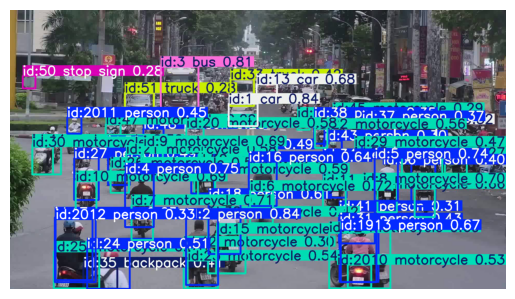

In [16]:
import cv2
from matplotlib import pyplot as plt

# Đọc video
video_path = '/content/run/vietnam-2_tracked.mp4'
cap = cv2.VideoCapture(video_path)

# Lấy một khung hình cụ thể (ví dụ, lấy khung hình đầu tiên)
ret, frame = cap.read()
cap.release()

if ret:
    # Xử lý khung hình bằng YOLO (nếu cần)
    results = model.track(frame, persist=True, show=False)

    # Lấy khung hình đã xử lý
    processed_frame = results[0].plot()

    # Chuyển đổi từ BGR sang RGB để hiển thị trong matplotlib
    processed_frame_rgb = cv2.cvtColor(processed_frame, cv2.COLOR_BGR2RGB)

    # Hiển thị ảnh bằng matplotlib
    plt.imshow(processed_frame_rgb)
    plt.axis('off')  # Tắt trục
    plt.show()

else:
    print("Không thể đọc video!")
